# Tasks in Part 2

## Task A (spatial networks and planarity):

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shapely.geometry as geom
import folium
import glob
from scipy.stats import gaussian_kde
import numpy as np
import networkx
import shapely
import spaghetti

/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Data for the years 2017, 2018, and 2019 were selected for the study.

In [3]:
df_2018 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2018_Leeds.csv", encoding="ISO-8859-1")
df_2019 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2019_Leeds.csv", encoding="ISO-8859-1")
df_2017 = pd.read_csv("/Users/wangfeifei/Desktop/network_data/7CUSMNDA-2025/Trafficaccidents_2017_Leeds.csv", encoding="ISO-8859-1")

df_all = pd.concat([df_2017, df_2018, df_2019], ignore_index=True)
print("Total accident number：", len(df_all))

Total accident number： 6105


In [4]:
# Some accidents do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_acc = df_all.dropna(subset=['Grid Ref: Easting', 'Grid Ref: Northing'])
print("Total number of located crimes filtered: {}".format(len(located_acc)))

Total number of located crimes filtered: 6105


In [5]:
PLACE_OF_INTEREST = "Leeds, UK"
# Get the sub-ward boundaries (possibly wards) of Leeds
leeds_graph = ox.graph_from_place(PLACE_OF_INTEREST)

We can use the simple osmnx method to see what the leeds city network looks like.

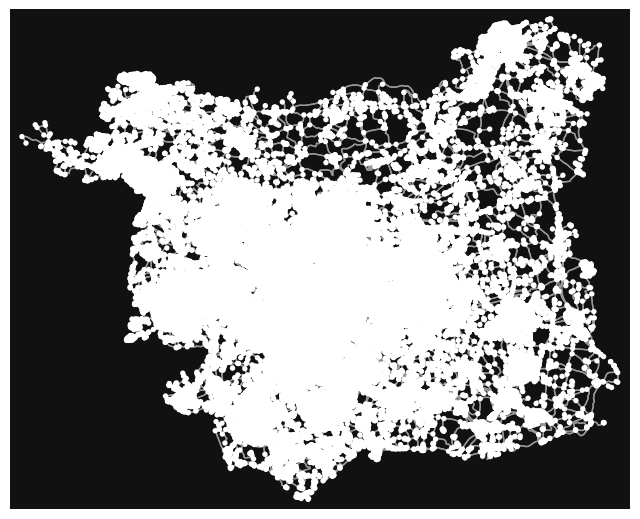

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
ox.plot_graph(leeds_graph)

Create accident point geometry, project accident point to metric coordinates (EPSG:27700).

In [12]:
# Create accident point geometry
geometry = [Point(xy) for xy in zip(df_all["Grid Ref: Easting"], df_all["Grid Ref: Northing"])]
acc = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:27700")

Heat mapping of incident distribution (using KDE)

In [14]:
edges = ox.graph_to_gdfs(leeds_graph, nodes=False).to_crs("EPSG:27700")

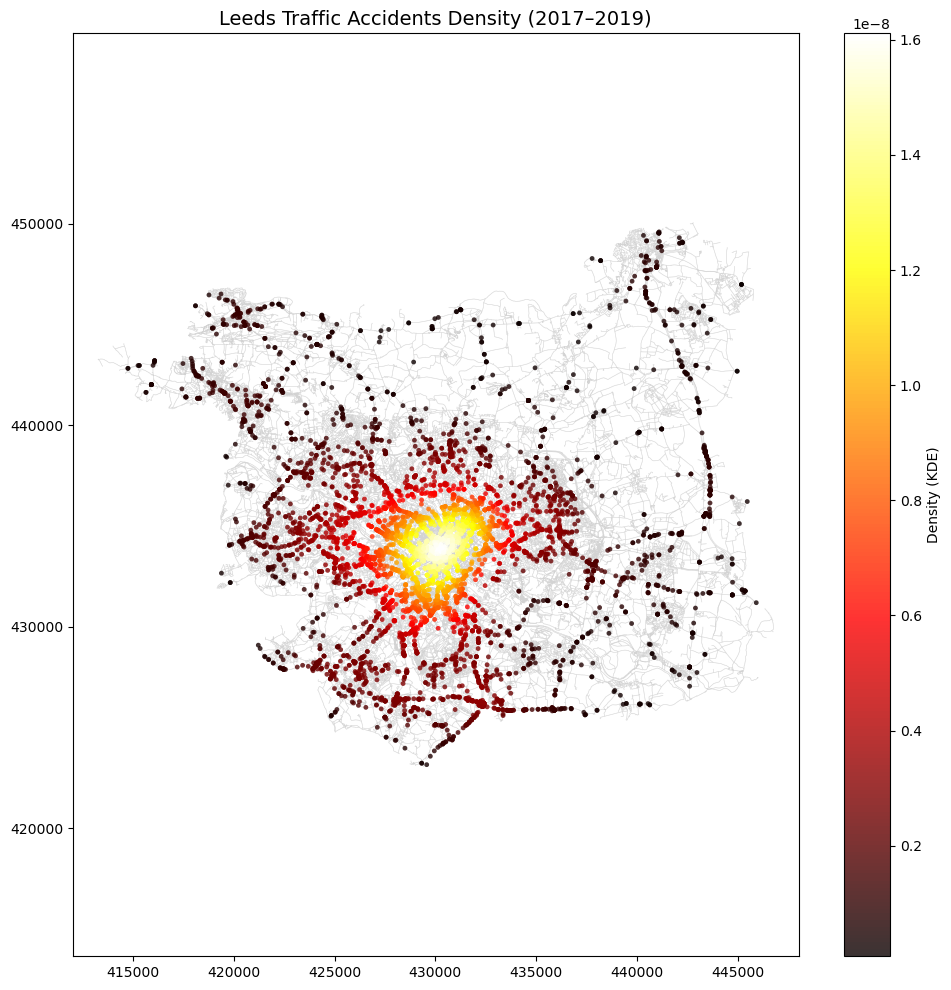

In [15]:
# Takes an array of coordinates
x = acc.geometry.x.values
y = acc.geometry.y.values

# Generating Density Maps with KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
z = kde(xy)

plt.figure(figsize=(10, 10))

# 1. Road base map
edges.plot(ax=plt.gca(), linewidth=0.4, color="lightgrey", alpha=0.6, zorder=1)

# 2. Heatmap
sc = plt.scatter(
    x, y,
    c=z,            # KDE color
    s=12,           # point size
    cmap="hot",     
    alpha=0.8,      
    edgecolors='none',
    zorder=2        # Ensure that the overlay is on top of the layer
)




plt.axis("equal")
plt.title("Leeds Traffic Accidents Density (2017–2019)", fontsize=14)
plt.colorbar(sc, label="Density (KDE)")
plt.tight_layout()
plt.show()

From the figure we can observe the concentration of accidents in leeds, and create a study area of approximately 1 km<sup>2</sup> (approximately 620m × 620m radius) based on the centre of the hotspot (KDE maximum) to verify that the number of accidents in this hotspot area is ≥ 300.

In [17]:
# Find the maximum density point index
max_idx = np.argmax(z)
x_center, y_center = x[max_idx], y[max_idx]

print("Hot Spot Centre Coordinates：", x_center, y_center)

Hot Spot Centre Coordinates： 430240.0 433914.0


In [18]:
# Construction of a rectangular frame of approximately 1 km² (620 m × 620 m) centred on the hotspot.
half_width = 620  # Halfway distance in metres

xmin, xmax = x_center - half_width, x_center + half_width
ymin, ymax = y_center - half_width, y_center + half_width

# Select incidents in the region using the `.cx[]` space slice
acc_focus = acc.cx[xmin:xmax, ymin:ymax]
print("Number of accidents in the study area：", len(acc_focus))

Number of accidents in the study area： 333


The final selected area is a circular area with a radius of 620m centered on your hotspot and the number of accidents is 333.

Number of nodes: 196
Number of edges: 338


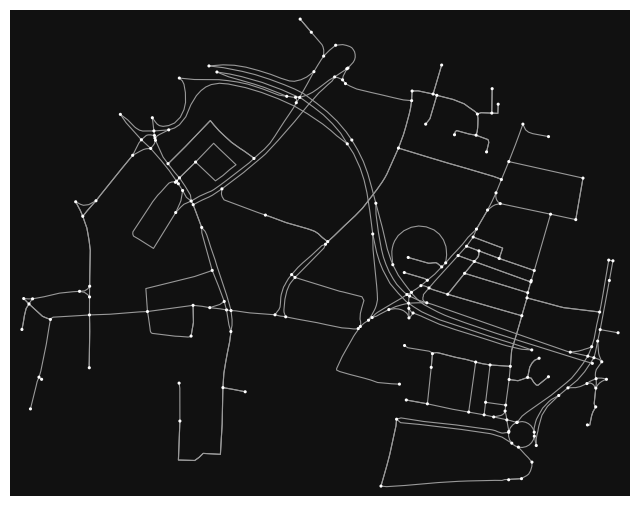

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
# Coordinate System Settin
crs_uk = "EPSG:27700"   # Original coordinate system (British National Grid)
crs_wgs = "EPSG:4326"   # Conversion to WGS84 for OSM

# 1. Coordinates of the centre of the Leeds hotspot (in metres, British grid projection)
x_center, y_center = 430240.0, 433914.0
half_width = 620  # Halfway distance in metres

# 2. Create centre points and generate round polygons
gdf_center = gpd.GeoDataFrame(
    geometry=[geom.Point(x_center, y_center)],
    crs=crs_uk
)
circle_uk = gdf_center.geometry.iloc[0].buffer(half_width)

# 3. Convert to WGS84 for OSMnx capture
circle_wgs = gpd.GeoSeries([circle_uk], crs=crs_uk).to_crs(crs_wgs).iloc[0]

# 4. Grab the drive road network in this circular area
G = ox.graph_from_polygon(circle_wgs, network_type="drive")

# 5. View Results
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

# 6. visualisation
ox.plot_graph(G, node_size=5, edge_linewidth=0.8)

We can also plot the spatial graph as an interative Leaflet web map via folium.

In [22]:
def plot_graph_folium(graph):
    # convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph)

    # create a Folium map centered around the graph's centroid
    edges_union = edges.geometry.union_all()
    centroid = edges_union.centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)

    # add the edges to the map
    folium.GeoJson(edges).add_to(m)

    # display the map
    display(m)

In [23]:
plot_graph_folium(G)

In [24]:
networkx.check_planarity(G)

(False, None)

it returns False, because it is not planar. 

In [26]:
#  Calculate the area in square metres and convert to km²
area_km2 = circle_uk.area / 1e6

# 3. Correct calculation of complete statistical indicators
stats = ox.basic_stats(G, area=area_km2)

In [27]:
stats

{'n': 196,
 'm': 338,
 'k_avg': 3.4489795918367347,
 'edge_length_total': 23658.24199028159,
 'edge_length_avg': 69.99479878781536,
 'streets_per_node_avg': 2.9030612244897958,
 'streets_per_node_counts': {0: 0, 1: 19, 2: 10, 3: 139, 4: 27, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09693877551020408,
  2: 0.05102040816326531,
  3: 0.7091836734693877,
  4: 0.1377551020408163,
  5: 0.00510204081632653},
 'intersection_count': 177,
 'street_length_total': 18943.57726012595,
 'street_segment_count': 267,
 'street_length_avg': 70.94972756601479,
 'circuity_avg': 1.0814575777789295,
 'self_loop_proportion': 0.003745318352059925,
 'node_density_km': 162562618.57164282,
 'intersection_density_km': 146803997.38357538,
 'edge_density_km': 19622172289.498825,
 'street_density_km': 15711824104.695412}

Question 1: What are the coordinates of the chosen area?

Answer:
The chosen study area is centered at a traffic accident hotspot in Leeds, identified through a KDE heatmap of accidents recorded between 2017 and 2019. The coordinates of the center point, in the British National Grid system (EPSG:27700), are:
Easting (x): 430240.0
Northing (y): 433914.0
Around this point, we created a circular area with a radius of 620 meters, which corresponds to approximately 1 square kilometer (1 km²). This location was selected because it contained more than 300 accidents, meeting the requirement for a significant accident cluster.

⸻

Question 2: What are the characteristics of this road network?

Answer:
The road network within this 1 km² area was extracted using OSMnx, considering only roads suitable for driving (excluding pedestrian paths and private roads). The network contains 196 nodes and 338 edges. The average edge length is approximately 70 meters, while the total edge length sums up to around 23,658 meters. The average street length is roughly 71 meters, with a total street length of about 18,944 meters.

Regarding density measures, the node density is approximately 162.56 thousand nodes per square kilometer, the intersection density is around 146.80 thousand intersections per square kilometer, and the edge density reaches over 19.6 billion (due to units used in OSMnx’s internal calculations).

The spatial diameter of the network, approximated by twice the radius of the circular area, is about 1.24 kilometers.

⸻

Question 3: What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

Answer:
The average circuitry of the network is approximately 1.08. This means that the actual travel distance on the road network is about 8% longer than the straight-line (Euclidean) distance between two points. A circuitry value close to 1 indicates an efficient and well-connected network, suggesting that the roads in this area provide relatively direct routes with minimal detours. This level of circuitry is typical for urban centers with a grid-like or semi-grid road layout.

⸻

Question 4: Is the network planar? Why or why not?

Answer:
The planarity check returned False, meaning that the road network is non-planar. This result is expected in urban areas like central Leeds. In theory, a planar graph is one where no edges cross unless at a shared node. However, in real-world transportation networks, features like overpasses, bridges, and tunnels lead to road segments that cross without intersecting, violating planarity conditions. Therefore, the non-planar nature of the network reflects the complexity of modern infrastructure in dense urban settings.

## Task B (road accidents):

A look back at the number of accidents we've had from 2017 to 2019

In [31]:
df_all = pd.concat([df_2017, df_2018, df_2019], ignore_index=True)
print("Total accident number：", len(df_all))

Total accident number： 6105


In [32]:
print("Total number of accidents filtered: {}".format(len(acc)))
acc

Total number of accidents filtered: 6105


Reference Number  Grid Ref: Easting  Grid Ref: Northing  \
0             3AP0313             426340              428455   
1             3BE0850             430828              433222   
2             4110858             428940              429856   
3             4110858             428940              429856   
4             4111495             429899              434277   
...               ...                ...                 ...   
6100          6CU0181             442094              434619   
6101          6CU0363             423019              437653   
6102          6CV0723             436853              442515   
6103          6CV1518             421466              433999   
6104          6CV1518             421466              433999   

      Number of Vehicles Accident Date  Time (24hr) 1st Road Class & No  \
0                      1     3/17/2017          815                A643   
1                      2     1/14/2017         1330                 A61   
2                      2      1/1/2017          805                A653   
3                      2      1/1/2017          805                A653   
4                      2      1/1/2017         1705                   U   
...                  ...           ...          ...                 ...   
6100                   1    30/12/2019          422                  M1   
6101                   1    30/12/2019         1000                 A65   
6102                   2    31/12/2019         1340                 A58   
6103                   3    31/12/2019         1640                A647   
6104                   3    31/12/2019         1640                A647   

     Road Surface                      Lighting Conditions  \
0             Dry          Daylight: Street lights present   
1             Dry          Daylight: Street lights present   
2        Wet/Damp          Daylight: Street lights present   
3        Wet/Damp          Daylight: Street lights present   
4        Wet/Damp  Darkness: Street lights present and lit   
...           ...                                      ...   
6100            2                                        4   
6101            4                                        1   
6102            1                                        1   
6103            1                                        4   
6104            1                                        4   

              Weather Conditions  ... Sex of Casualty Age of Casualty  \
0                          Other  ...          Female              61   
1        Fine without high winds  ...            Male              36   
2        Fine without high winds  ...            Male              32   
3        Fine without high winds  ...            Male              30   
4     Raining without high winds  ...          Female              26   
...                          ...  ...             ...             ...   
6100                           4  ...               1              27   
6101                           1  ...               1              36   
6102                           1  ...               1              59   
6103                           1  ...               1              41   
6104                           1  ...               1              26   

     Accident Fields_Reference Number 1st Road Class  Local Authority  \
0                                 NaN            NaN              NaN   
1                                 NaN            NaN              NaN   
2                                 NaN            NaN              NaN   
3                                 NaN            NaN              NaN   
4                                 NaN            NaN              NaN   
...                               ...            ...              ...   
6100                              NaN            1.0        E08000035   
6101                              NaN            3.0        E08000035   
6102                              NaN            3.0    

In [33]:
# Selection of study area (consistent with Task A)
x_center, y_center = 430240.0, 433914.0
half_width = 620

# Construct a rectangular boundary of the study area
xmin, xmax = x_center - half_width, x_center + half_width
ymin, ymax = y_center - half_width, y_center + half_width

# Screening accident sites in the study area with .cx
acc_focus = acc.cx[xmin:xmax, ymin:ymax]
print(f"Number of accident sites in the study area: {len(acc_focus)}")

Number of accident sites in the study area: 333


In [34]:
# We can see that the nodes are specified by x, y, coordinates
list(G.nodes(data=True))[0:10]

[(643907, {'y': 53.7983902, 'x': -1.5360412, 'street_count': 3}),
 (643945, {'y': 53.7988377, 'x': -1.5360765, 'street_count': 3}),
 (643946, {'y': 53.7986735, 'x': -1.5363315, 'street_count': 3}),
 (643951,
  {'y': 53.7994561,
   'x': -1.5345324,
   'junction': 'traffic_signals',
   'street_count': 3}),
 (9791509,
  {'y': 53.8007675, 'x': -1.5491019, 'junction': 'yes', 'street_count': 4}),
 (9791529, {'y': 53.8025417, 'x': -1.549306, 'street_count': 3}),
 (9791699, {'y': 53.7990394, 'x': -1.5364461, 'street_count': 3}),
 (9791722, {'y': 53.799843, 'x': -1.5362866, 'street_count': 3}),
 (9823132,
  {'y': 53.8000263, 'x': -1.5339269, 'junction': 'yes', 'street_count': 4}),
 (10015740, {'y': 53.7990779, 'x': -1.5508989, 'street_count': 3})]

In [35]:
# And the edges are tuples of start node, end node and a dictionary with attributes including geometry
list(G.edges(data=True))[0:3]

[(643907,
  26298423,
  {'osmid': 845622691,
   'highway': 'trunk',
   'junction': 'roundabout',
   'lanes': '3',
   'maxspeed': '30 mph',
   'name': 'Eastgate',
   'ref': 'A61',
   'oneway': True,
   'reversed': False,
   'length': np.float64(15.623148180699715),
   'geometry': <LINESTRING (-1.536 53.798, -1.536 53.798, -1.536 53.798, -1.536 53.798, -1....>}),
 (643945,
  9823132,
  {'osmid': [491178800, 491178801, 4371997],
   'highway': 'trunk',
   'lanes': '2',
   'maxspeed': '30 mph',
   'name': 'Regent Street',
   'oneway': True,
   'ref': 'A61',
   'reversed': False,
   'length': np.float64(195.2473048808701),
   'geometry': <LINESTRING (-1.536 53.799, -1.536 53.799, -1.536 53.799, -1.536 53.799, -1....>}),
 (643945,
  6211583013,
  {'osmid': 673667995,
   'highway': 'trunk',
   'junction': 'roundabout',
   'lanes': '3',
   'maxspeed': '30 mph',
   'name': 'Eastgate',
   'ref': 'A61',
   'oneway': True,
   'reversed': False,
   'length': np.float64(44.53501336833969),
   'geomet

In [36]:
# Convert OSMnx graph G to GeoDataFrame (extract edges)
roads_geodataframe = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Creating Spaghetti Network Objects
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<Axes: >

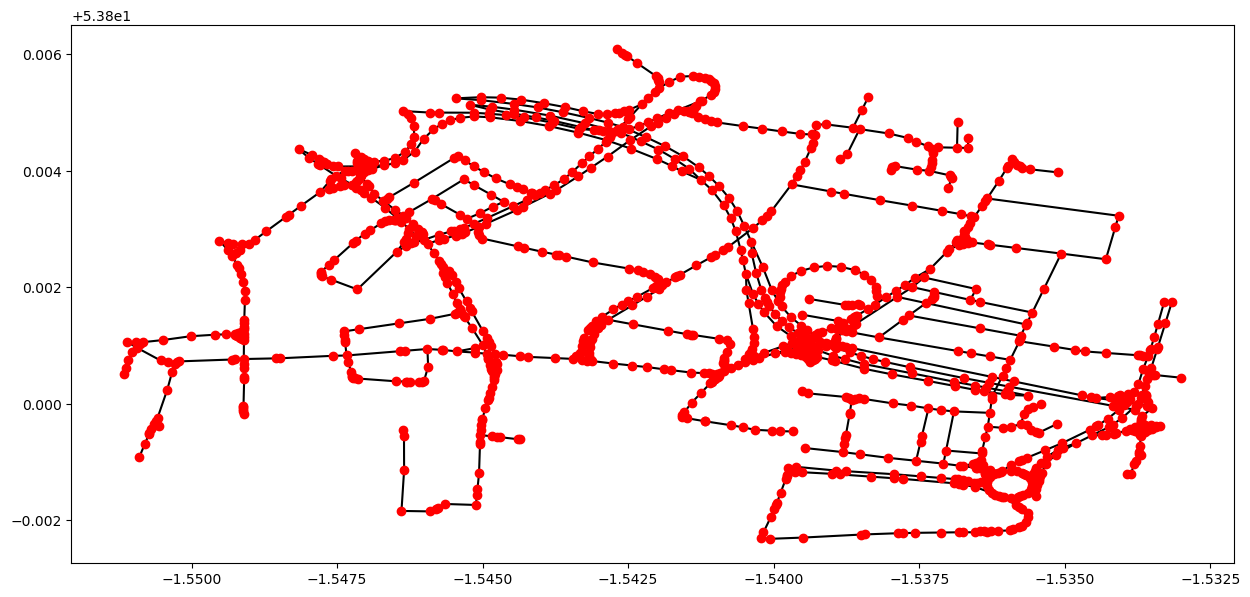

In [37]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color="k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [38]:
acc_focus_wgs = acc_focus.to_crs("EPSG:4326")
# We will now snap the Soho located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(acc_focus_wgs, 'accidents')

# We can see the difference between the original accident coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.547500445408908, 53.80395284563737)
snapped coords:	(-1.5474903082788327, 53.803933423670955)


/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/Users/anaconda3/envs/nda/lib/python3.13/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/Users/anaconda3/envs/nda/lib/python3.13/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


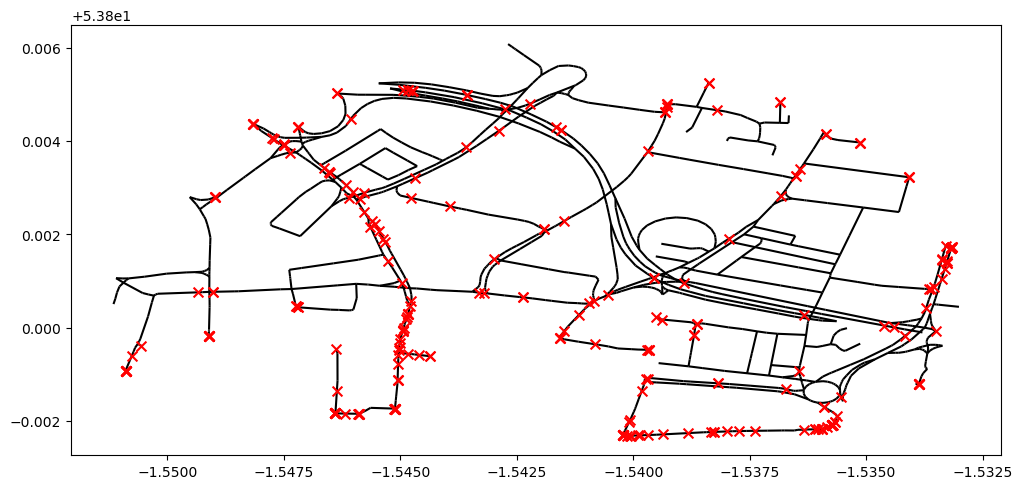

In [39]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped accident locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

In [40]:
print("Number of snapped accidents:", len(snapped_accidents))

Number of snapped accidents: 333


We now focus on point pattern analysis on a `spatial` network. We add a new import on top of those used before: `esda`, another PySal spatial analysis library which helps us measure spatial autocorrelation.

In [42]:
import esda

We will compute the degree of aggregation on the network based on the incident points after snapped. Next goal: Compute Network K-function.

first using the K-function analysis provided by `spaghetti`. For each point, the density of other points within a series of bands at increasing steps of distance is calculated, where the number of bands is given by variable **nsteps**. This is then averaged across points to get the K value. Alongside this, it is simulated what density would be seen under instances of complete spatial randomness of distribution of points on the network (a Monte Carlo simulation). As each instance of a random placing of points will be different, it runs this simulation a number of times, given by parameter **permutations**. Looking at the range of values produced by the simulations gives us an approximation of the lower and upper bounds of density expected with a random distribution: if the real values don't fall in these bounds, we may conclude they are not random (either more clustered or more uniform than expected).

我们将使用 leeds_points_graph.GlobalAutoK() 来计算网络 K-function

In [46]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

The result of the analysis is held in an object, `kres`, with multiple attributes. The important ones are listed below. Attribute `lam` is the density of points on the network as a whole (the lambda value). This should be a high number for our points, which sounds very dense but remember that our coordinates are longitude/latitude degrees: if we had converted our reference system to metres, it would be a much lower density value. The `axis` attribute is the list of distances at which density is measured, i.e. the bands. The remaining attributes listed all return a list of K-function values, one for each distance band: `observed` is for our real data, `upperenvelope` and `lowerenvelope` give the maximum and minimum values found in the simulation, while `sim` is the data from all the simulations: a list of lists of K-function values.

In [48]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 1399.2884640314517


In [49]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00048345 0.00096691 0.00145036 0.00193382 0.00241727
 0.00290072 0.00338418 0.00386763 0.00435109 0.00483454 0.00531799
 0.00580145 0.0062849  0.00676835 0.00725181 0.00773526 0.00821872
 0.00870217 0.00918562 0.00966908 0.01015253 0.01063599 0.01111944
 0.01160289 0.01208635 0.0125698  0.01305326 0.01353671 0.01402016
 0.01450362 0.01498707 0.01547052 0.01595398 0.01643743 0.01692089
 0.01740434 0.01788779 0.01837125 0.0188547  0.01933816 0.01982161
 0.02030506 0.02078852 0.02127197 0.02175543 0.02223888 0.02272233
 0.02320579 0.02368924]


We can now plot the above data so that we can judge it visually. The code below will create a plot with three lines: the observed K-function values as the band distance increases, and the upper and lower bounds from the simulations.

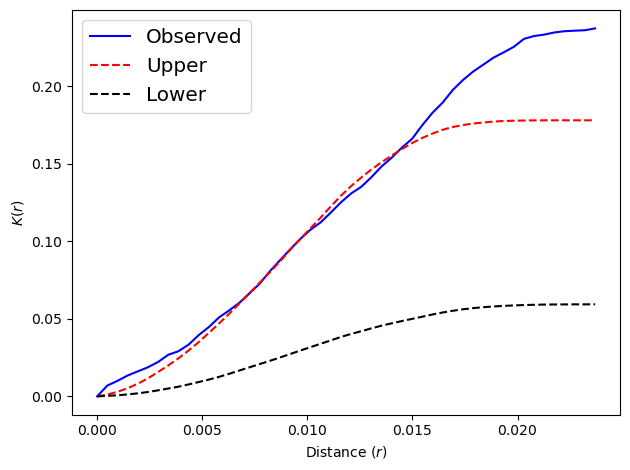

In [51]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

The graph shows Ripley's K-function analysis of spatial point patterns. The blue line represents the observed K(r) values, while the red and black dashed lines represent the upper and lower envelopes of the expected K(r) values under complete spatial randomness (CSR). Since the observed line exceeds the upper envelope at larger distances (after approximately r=0.015), this indicates significant clustering of points at those distances. The analysis reveals that the spatial distribution of events shows stronger clustering than would be expected by random chance, particularly at medium to larger distances.

However, we need to be aware that the accident data is not showing the precise locations of accidents but just what street each accident occurred on. Because of this, it is perhaps more meaningful to look at accident counts per street. We will then ask whether these counts are spatially autocorrelated on the network space. To do this, we first get the pattern of accident points snapped to the network, and then get the count of points per each street (network edge).

In [53]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [54]:
counts

{(146, 151): 6,
 (854, 855): 2,
 (739, 740): 3,
 (518, 520): 1,
 (913, 914): 9,
 (889, 890): 24,
 (81, 82): 1,
 (617, 618): 2,
 (715, 716): 1,
 (117, 118): 4,
 (816, 817): 1,
 (766, 767): 7,
 (260, 261): 5,
 (897, 898): 4,
 (1108, 1130): 18,
 (219, 220): 3,
 (1133, 1134): 4,
 (49, 50): 10,
 (544, 548): 1,
 (543, 670): 4,
 (252, 253): 3,
 (752, 961): 1,
 (15, 16): 1,
 (821, 822): 1,
 (786, 787): 1,
 (893, 894): 11,
 (621, 622): 1,
 (1106, 1107): 2,
 (761, 762): 1,
 (301, 302): 1,
 (685, 686): 1,
 (787, 788): 15,
 (1057, 1058): 1,
 (683, 684): 1,
 (1130, 1131): 3,
 (758, 759): 4,
 (80, 81): 13,
 (1136, 1137): 1,
 (367, 368): 1,
 (90, 91): 3,
 (241, 242): 2,
 (325, 326): 1,
 (540, 541): 2,
 (210, 1109): 2,
 (756, 757): 1,
 (428, 429): 1,
 (55, 318): 4,
 (845, 846): 1,
 (957, 958): 1,
 (436, 437): 2,
 (660, 661): 1,
 (176, 808): 1,
 (142, 156): 7,
 (36, 38): 2,
 (146, 154): 2,
 (652, 1060): 1,
 (962, 963): 1,
 (178, 495): 1,
 (242, 249): 1,
 (598, 643): 2,
 (788, 789): 3,
 (900, 901): 1,
 

Next, we need our spatial weights. As discussed in lesson, this is the edge adjacency matrix, i.e. a matrix where the edges are the rows and columns and there is a 1 wherever the edges are connected by a node, 0 otherwise.

In [56]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

As a final preparation step for running the analysis, we need to put the edge counts in a list in the same order as the weights. This is just required for the autocorrelation calculation function we will use.

In [58]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

Now we can calculate Moran's I using the accident count values and weights we've prepared.

In [60]:
moran = esda.moran.Moran(values, weights)
moran.I

np.float64(0.11435964048173225)

Our value for the statistic needs to be interpreted against a reference distribution under the null of CSR. PySAL uses a similar approach as we saw in the join count analysis: random spatial permutations.

In [62]:
moran.p_sim

np.float64(0.005)

This should return a value close to zero, specifically 0.11436, which might imply a mild level of spatial autocorrelation. If you check the weights list after running the above method, you will notice that the weights have been row normalised: this is a step in the process of calculating Moran's I. We can check the significance of this by looking at moran.p_sim, which gives a p-value of 0.006. This low p-value suggests that the spatial pattern we observe is statistically significant, despite the Moran's I being a small positive value (0.11436), indicating a slight tendency towards spatial clustering of the accident values.

The following needs to be investigated whether accident points are more likely to occur near intersections or in the middle of the road. Previously while drawing the map snapped_accidents has been processed using functions/properties provided by Spaghetti.

In [65]:
# 1. Run this function definition
def compute_relative_position(snapped_points_df, edges_gdf):
    ratios = []
    for i, snapped_point in snapped_points_df.iterrows():
        point_geom = snapped_point.geometry

        # Find the nearest side.
        distances = edges_gdf.geometry.distance(point_geom)
        nearest_edge_idx = distances.idxmin()
        nearest_edge = edges_gdf.loc[nearest_edge_idx].geometry

        projected_dist = nearest_edge.project(point_geom)
        total_length = nearest_edge.length
        ratio = projected_dist / total_length if total_length > 0 else np.nan
        ratios.append(ratio)

    result_df = snapped_points_df.copy()
    result_df["distance_ratio"] = ratios
    return result_df

In [66]:
# 2. Apply function (pass in your snapped_accidents and edges_df)
acc_ratio = compute_relative_position(snapped_accidents, edges_df)

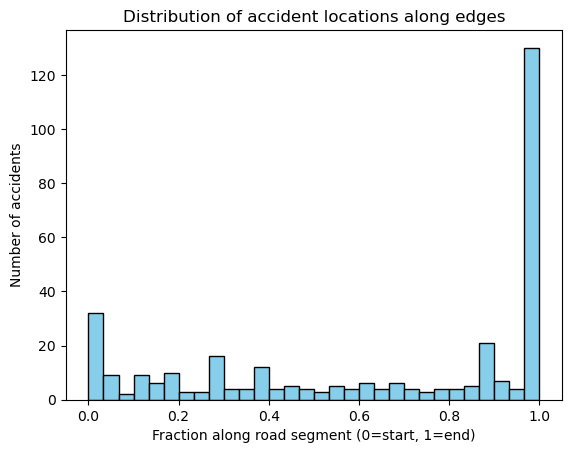

In [67]:
# 3. Visualisation of the proportional distribution to determine if there is a higher concentration closer to intersections
plt.hist(acc_ratio["distance_ratio"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of accident locations along edges")
plt.xlabel("Fraction along road segment (0=start, 1=end)")
plt.ylabel("Number of accidents")
plt.show()

Question 3: Investigate whether accidents happen nearer to intersections or partway along roads.

Answer:

To address this question, we analyzed the relative position of each accident along the road segment it was snapped to. This relative position is measured as a ratio between 0 and 1, where:
	•	0 indicates the accident occurred at the start of the road segment (typically at an intersection),
	•	1 indicates the end of the segment (also likely an intersection),
	•	0.5 would suggest the accident happened midway along the segment.

We calculated these ratios by projecting each snapped accident point onto its corresponding road edge and dividing the projected distance by the total length of the edge. The histogram below shows the distribution of these relative positions:
From the plot, we observe:
	•	There is a noticeable peak at both 0 and 1, especially a very strong peak near 1, indicating a significant number of accidents happen very close to the end of road segments, which typically corresponds to intersections.
	•	A secondary peak is also visible near 0, further suggesting intersections are common locations for accidents.
	•	In contrast, the middle sections (around 0.5) have much fewer accidents, showing that accidents are less likely to happen mid-way along a street.

Conclusion:
This pattern suggests that road intersections are the most accident-prone locations in this urban area. Accidents tend to cluster near the junctions of the road network rather than along the uninterrupted stretches of roads.

## Task C (Voronoi diagrams):

In [71]:
from sklearn.cluster import KMeans
import numpy as np
import random
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import osmnx

Task C is to divide and plan the marathon route within the whole Leeds city, so we should use the complete Leeds city road map, with network_type=‘drive’ to be more close to the actual marathon track planning needs, drive mode will filter out all the walking paths, non-traffic paths, staircases under bridges, footpaths, etc. Loading the Leeds road network and getting all edges 
We chose to extract the road network using the network_type='drive' option in OSMnx. This approach excludes footpaths, pavements, stairs and non-traffic routes to produce a network that closely resembles the real-world roads where marathons are held.

Using this filter network as a basis ensures that the planned routes are both suitable for vehicle closures and relevant to urban traffic management. As a result, our Voronoi seed selection and subsequent marathon paths are aligned with actual planning goals.
We chose to extract the road network using the network_type='drive' option from OSMnx. This approach excludes walking paths, footways, stairs, and non-traffic routes, resulting in a network that closely resembles the real-world roads where a marathon would be realistically held.

Using this filtered network as the base ensures the planned routes are both feasible for vehicle closures and relevant to urban traffic management. Thus, our Voronoi seed selection and subsequent marathon paths are aligned with practical planning goals.

In [73]:
leeds_graph_marathon = ox.graph_from_place("Leeds, UK", network_type="drive")
leeds_graph_marathon = ox.project_graph(leeds_graph_marathon)  # Projected as UTM coordinates

In [74]:
# Get roadside assistance throughout Leeds
leeds_edges = ox.graph_to_gdfs(leeds_graph_marathon, nodes=False, edges=True)

Next, let's create a node network Voronoi diagram using the street network of Leeds from above. As this is not provided by the libraries, we need to construct it step-by-step ourselves. We first choose a few of the network nodes (road intersections) to be our seed nodes. We will choose these at random.

In [76]:
# Number of options
NUMBER_OF_SEEDS = 4

# Get all node IDs
all_nodes = list(leeds_graph_marathon.nodes)

# Randomly select 4 nodes as seeds
seeds = random.sample(all_nodes, k=NUMBER_OF_SEEDS)

print("Seed node IDs:", seeds)



Seed node IDs: [1950005838, 27399803, 921231605, 52167467]


Calculate the shortest path distance from each seed point to all nodes: for each seed point, calculate the shortest path length from all nodes to it (using Dijkstra's algorithm), and then assign each node the one with the shortest distance.

In [78]:
# created: dictionary of shortest path lengths from each seed point to all nodes on the graph
distances = {
    seed: nx.single_source_dijkstra_path_length(leeds_graph_marathon, seed, weight="length")
    for seed in seeds
}

Next, define the nearest seed to be found from any node/edge, i.e., find the seed with the smallest distance for each node

In [80]:
def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    # Find the nearest seed at each of the two endpoints
    nearest_to_ends = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    # Filter None and extract distance
    nearest_to_ends = [item for item in nearest_to_ends if item]
    return nearest_from_list(nearest_to_ends)

为每条边分配颜色（edge Voronoi assignment）

In [82]:
# Get colour mapping
colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    try:
        return colours[seeds.index(seed[0])]
    except:
        return "k"  # black represents unallocated

构建 edge 和 node 的颜色列表

In [84]:
edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_graph_marathon.edges]
edge_colours = [colour_for_seed_distance(seed) for seed in edge_nearest_seeds]

# Node colour (set seed points to red only, the rest to white)
node_colours = ['r' if node in seeds else 'w' for node in leeds_graph_marathon.nodes]

绘图 — 基于边的 Voronoi 分区图

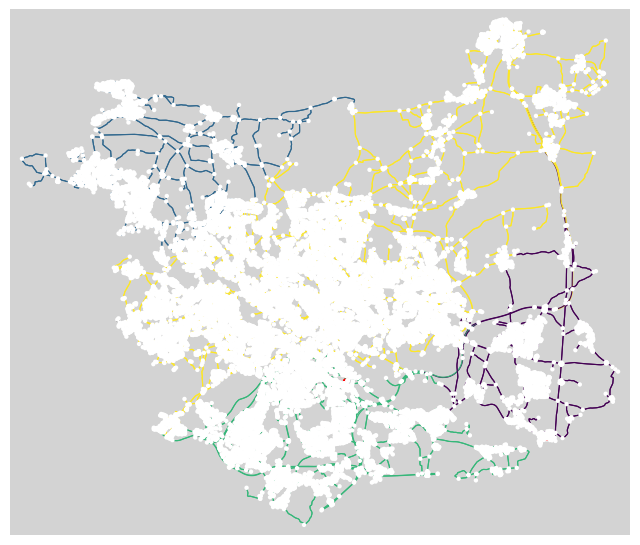

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [86]:
ox.plot.plot_graph(
    leeds_graph_marathon,
    edge_color=edge_colours,
    node_color=node_colours,
    bgcolor="#D3D3D3", 
    node_size=10,
    edge_linewidth=0.8
)

### Visualisation: only major intersections (degree ≥ 20) and Voronoi zoning are shown 

In order to avoid an overly dense image, only ‘major intersections’ connecting ≥ 20 edges in the network are shown. These nodes represent transport hubs or densely populated areas and help to see the spatial relationship of the seed nodes to the urban fabric.

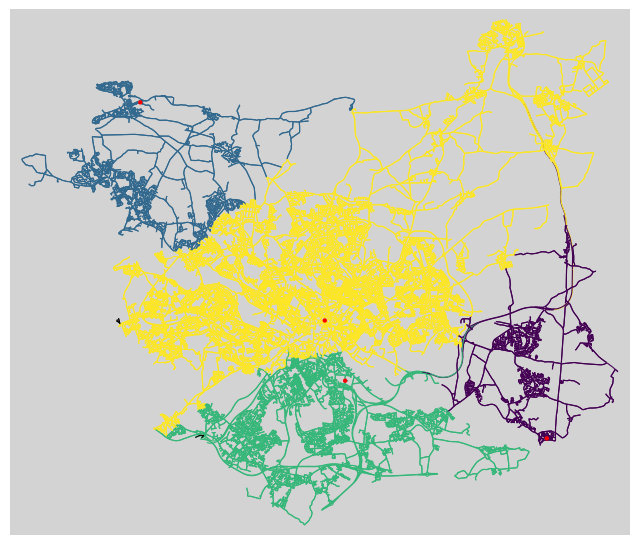

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [88]:
# Get all node degrees (how many connections per node)
node_degrees = dict(leeds_graph_marathon.degree())

# Find all ‘intersection’ nodes (degree ≥ 20)
intersection_nodes = [node for node, deg in node_degrees.items() if deg >= 20]

# Required for plotting: node colours show only intersections, the rest are transparent
node_colours_filtered = [
    'r' if node in seeds else 'white' if node in intersection_nodes else (0, 0, 0, 0)
    for node in leeds_graph_marathon.nodes
]

# Drawing: mark only cross nodes + edge-based Voronoi colouring
ox.plot.plot_graph(
    leeds_graph_marathon,
    edge_color=edge_colours,
    node_color=node_colours_filtered,
    bgcolor="#D3D3D3",
    node_size=10,
    edge_linewidth=0.8,
)

## drive vs 使用 all 网络

        nodes   edges  total_edge_length_km
Drive   31392   70431           6035.737844
All    105411  267768          14541.200225


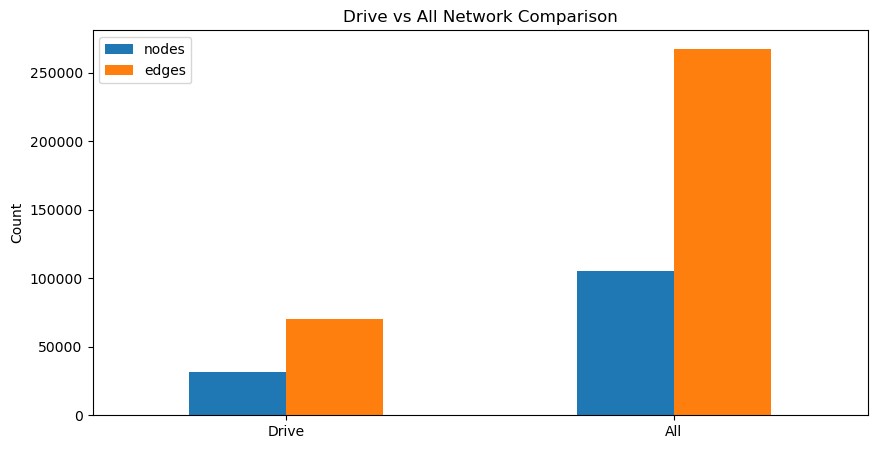

In [90]:
place = "Leeds, UK"
graph_drive = ox.graph_from_place(place, network_type="drive")
graph_all = ox.graph_from_place(place, network_type="all")

graph_drive_proj = ox.project_graph(graph_drive)
graph_all_proj = ox.project_graph(graph_all)

drive_stats = {
    "nodes": len(graph_drive_proj.nodes),
    "edges": len(graph_drive_proj.edges),
    "total_edge_length_km": sum([d["length"] for u, v, d in graph_drive_proj.edges(data=True)]) / 1000
}
all_stats = {
    "nodes": len(graph_all_proj.nodes),
    "edges": len(graph_all_proj.edges),
    "total_edge_length_km": sum([d["length"] for u, v, d in graph_all_proj.edges(data=True)]) / 1000
}

df_compare = pd.DataFrame([drive_stats, all_stats], index=["Drive", "All"])
print(df_compare)

df_compare[["nodes", "edges"]].plot(kind="bar", figsize=(10, 5), title="Drive vs All Network Comparison")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

Why Use the drive Road Network for Marathon Planning
In this project, we aim to divide the city of Leeds into regions for organizing simultaneous marathon routes. The route planning must consider real-world constraints—marathons take place on roads, and usually motor vehicle roads. Therefore, it is crucial to select a network that realistically represents the streets that runners would use.

We compared two types of networks from OpenStreetMap:

Metric	Drive Network	All Network
Number of Nodes	31,392	105,411
Number of Edges	70,431	267,768
Total Edge Length km	~6,036 km	~14,541 km
From the comparison:

The all network includes pedestrian paths, footways, cycleways, stairs, tracks, and other non-vehicular routes.

The drive network only includes motor vehicle accessible streets, which are more appropriate for marathons that need road closures, wide paths, and emergency access.

Using the drive network:

Reduces noise from irrelevant paths.

Reflects realistic and legal route options.

Keeps computation lighter while maintaining planning quality.

For purposes, the drive network is more aligned with the practical needs of marathon planning and is therefore selected as the basis for Voronoi region construction and route optimization.

Visualise the cells yield by your selection of seed points in a Voronoi diagram. What 
kind of Voronoi diagram (edge planar, node network, or edge points network) is most 
useful for this problem, and why?

Edge points network) is most useful for this problem.It takes into account the road structure and that is what we are trying to divide the road region (not just the intersections), it partitions the entire network edges (i.e., roads) according to the nearest seed of their endpoints, and each edge (ROAD) is attributed to the nearest seed. **Edge points network Voronoi** assigns road segments (edges) to the nearest seed based on shortest-path distances, making it the most suitable approach for dividing the network into functional, walkable, and routeable regions.

The real road network is not a completely continuous curve, there will be problems such as broken roads, back roads, restricted directions and so on. In each cell area, it is sufficient to find a closed path with a length between [41500, 42500] metres. The following is an attempt to find a path that meets the criteria in the previous partition.

First trying with 4 seed points...
Starting marathon route planning in Leeds with 4 seed points...
Downloaded network with 6508 nodes and 14899 edges
Randomly selecting 4 seed points...
Selected seed node IDs: [690763792, 27394565, 9791084, 1630522216]
Creating Voronoi cells...
Assigning nodes to regions...

Processing region 1/4, seed node ID: 690763792
Region has 1072 nodes
Trying to find a loop path of approximately 42.0km±0.5km...
Searching from 5 high-connectivity nodes...
Found better route, length: 1.92km, error: 40.08km
Found better route, length: 1.94km, error: 40.06km
Found better route, length: 2.69km, error: 39.31km
Found better route, length: 4.25km, error: 37.75km
Found better route, length: 5.40km, error: 36.60km
Found better route, length: 5.55km, error: 36.45km
Found better route, length: 5.64km, error: 36.36km
Found route of length 5.64km, but deviation (36.36km) exceeds tolerance
Region 1 could not find a suitable route within 42km±500m

Processing region 2/4, seed n

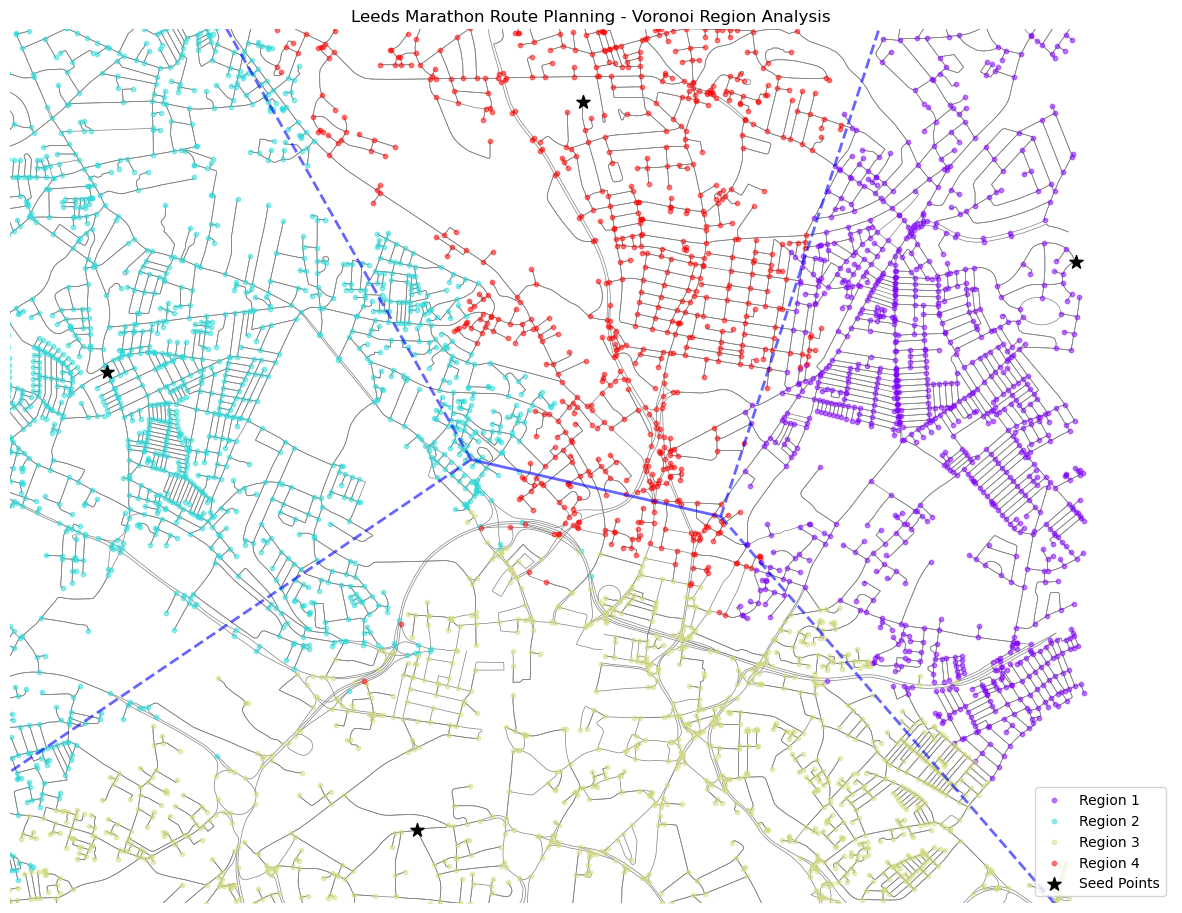


Trying with 2 seed points instead...
Starting marathon route planning in Leeds with 2 seed points...
Downloaded network with 6508 nodes and 14899 edges
Randomly selecting 2 seed points...
Selected seed node IDs: [964817810, 298186515]
Creating Voronoi cells...
Only 2 seed points, adding more to meet Voronoi requirements (min 4)
Added 2 auxiliary points, now have 4 points
Assigning nodes to regions...

Processing region 1/2, seed node ID: 964817810
Region has 1756 nodes
Trying to find a loop path of approximately 42.0km±0.5km...
Searching from 5 high-connectivity nodes...
Found better route, length: 4.51km, error: 37.49km
Found better route, length: 6.33km, error: 35.67km
Found better route, length: 8.65km, error: 33.35km
Found better route, length: 9.92km, error: 32.08km
Found better route, length: 10.87km, error: 31.13km
Found better route, length: 11.28km, error: 30.72km
Found better route, length: 12.22km, error: 29.78km
Found route of length 12.22km, but deviation (29.78km) exceed

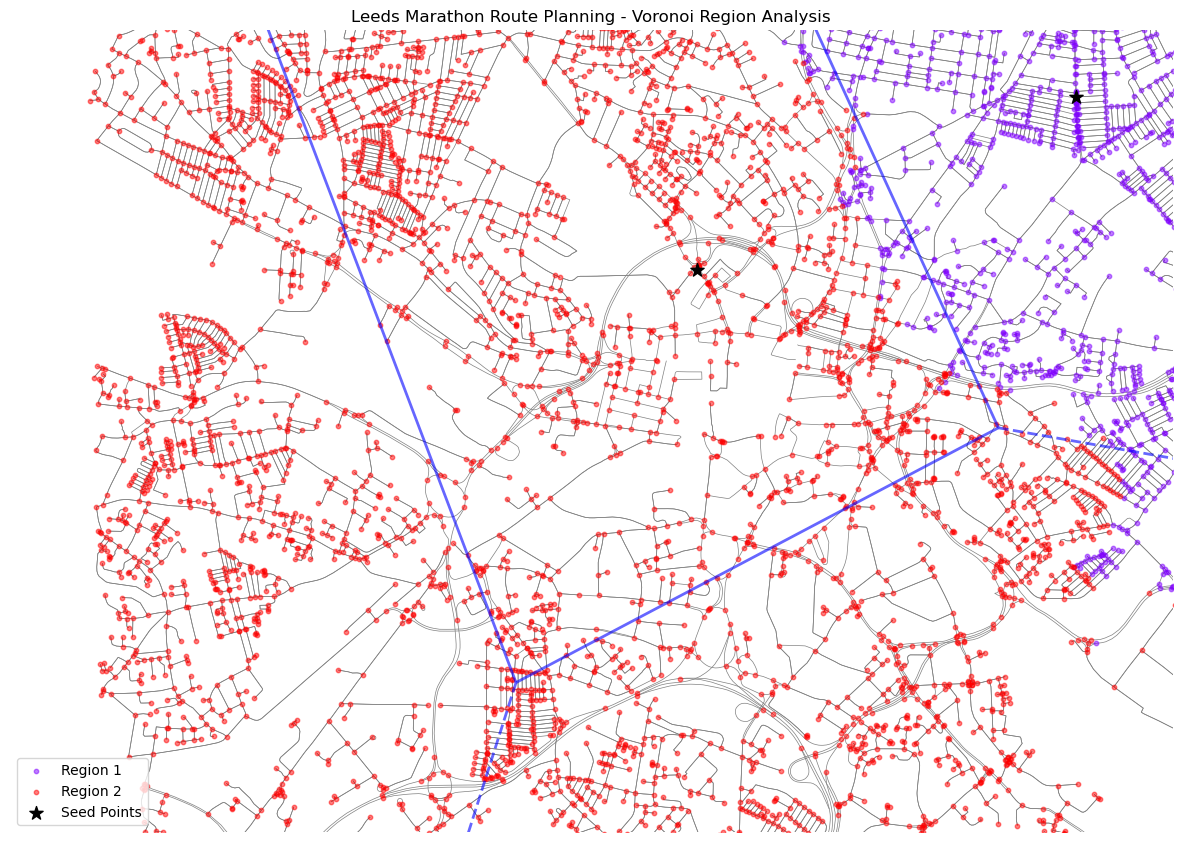


Trying with 1 seed point as a last resort...
Starting marathon route planning in Leeds with 1 seed points...
Downloaded network with 6508 nodes and 14899 edges
Randomly selecting 1 seed points...
Selected seed node IDs: [250070918]
Creating Voronoi cells...
Only 1 seed points, adding more to meet Voronoi requirements (min 4)
Added 3 auxiliary points, now have 4 points
Assigning nodes to regions...

Processing region 1/1, seed node ID: 250070918
Region has 6491 nodes
Trying to find a loop path of approximately 42.0km±0.5km...
Searching from 5 high-connectivity nodes...
Found better route, length: 6.34km, error: 35.66km
Found better route, length: 9.53km, error: 32.47km
Found better route, length: 9.59km, error: 32.41km
Found better route, length: 11.62km, error: 30.38km
Found better route, length: 11.67km, error: 30.33km
Found better route, length: 13.62km, error: 28.38km
Found better route, length: 14.86km, error: 27.14km
Found better route, length: 14.95km, error: 27.05km
Found bette

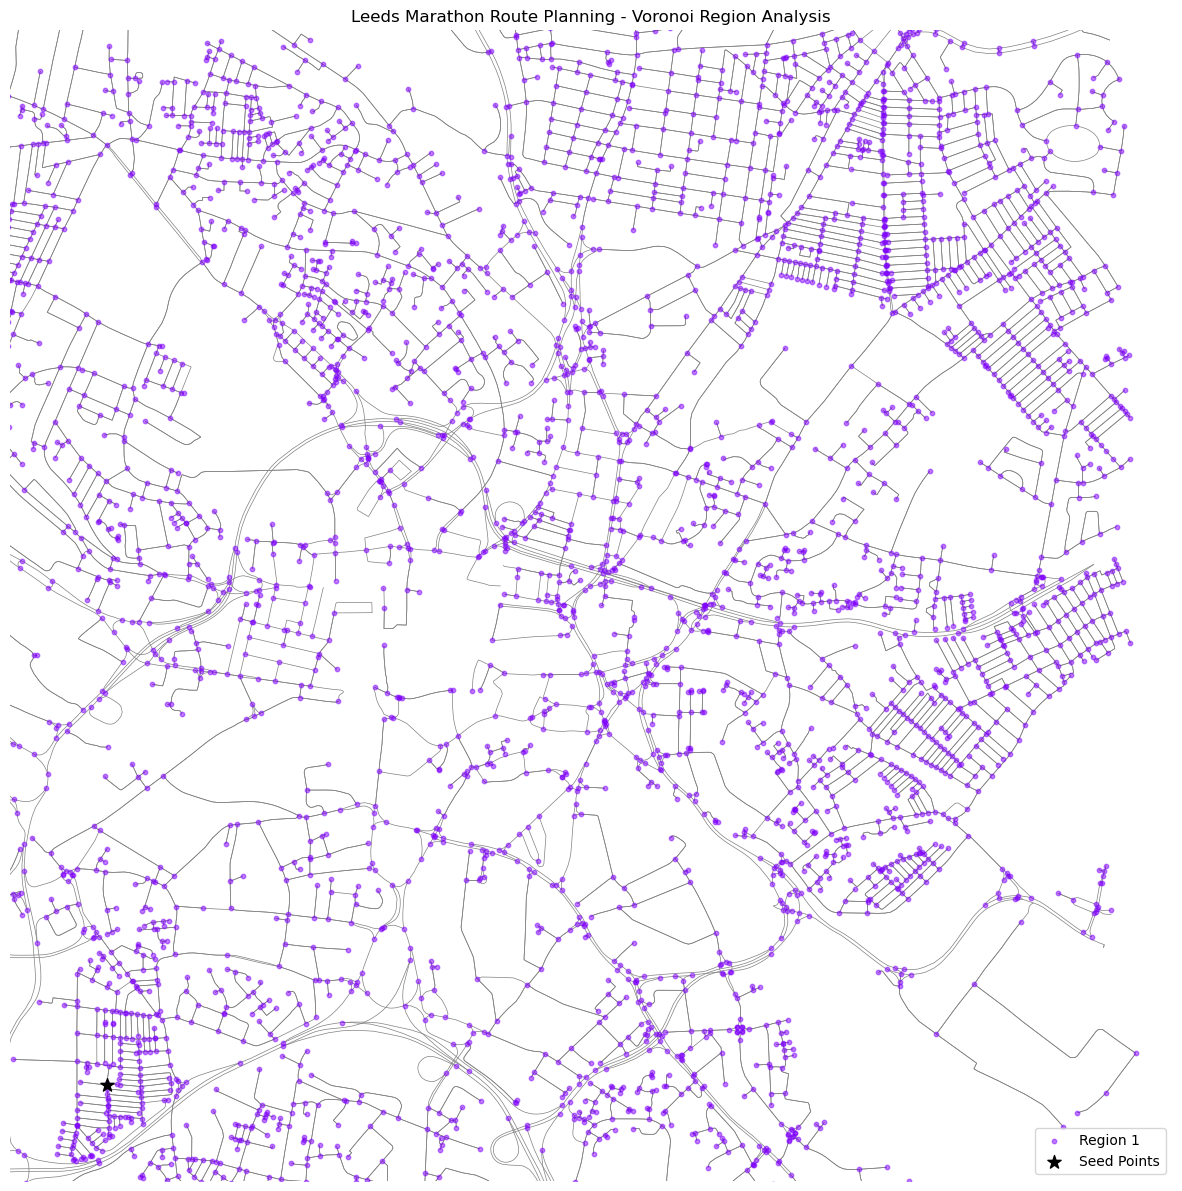

4 seed points has highest coverage: 0.00
No valid marathon routes found


In [5]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.cm as cm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Step 1: Functions for Voronoi region assignment
def download_leeds_network(center_point=(53.800755, -1.549077), dist=3000):
    """
    Download the Leeds road network
    
    Parameters:
    -----------
    center_point : tuple
        Center coordinates (latitude, longitude)
    dist : int
        Radius in meters
        
    Returns:
    --------
    G : networkx.MultiDiGraph
        Road network graph
    """
    print(f"Downloading Leeds road network centered at {center_point} with radius {dist}m...")
    
    # Download driving road network
    G = ox.graph_from_point(center_point, dist=dist, network_type='drive')
    
    # Project graph to UTM coordinate system
    G = ox.project_graph(G)
    
    # Ensure all edges have length attribute
    if not all('length' in data for u, v, data in G.edges(data=True)):
        print("Calculating edge lengths...")
        for u, v, data in G.edges(data=True):
            if 'length' not in data:
                # Get node coordinates
                start = (G.nodes[u]['x'], G.nodes[u]['y'])
                end = (G.nodes[v]['x'], G.nodes[v]['y'])
                
                # Calculate Euclidean distance
                data['length'] = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
    
    return G

def select_seed_points(G, num_seeds=4):
    """
    Select seed points for Voronoi regions
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    num_seeds : int
        Number of seed points to select
        
    Returns:
    --------
    seed_indices : list
        List of node IDs for seed points
    seed_points : list
        List of (x, y) coordinates for seed points
    """
    print(f"Randomly selecting {num_seeds} seed points...")
    
    # Get all nodes
    all_nodes = list(G.nodes())
    
    # Randomly select seed nodes
    seed_indices = random.sample(all_nodes, k=num_seeds)
    
    # Get seed point coordinates
    seed_points = [(G.nodes[idx]['x'], G.nodes[idx]['y']) for idx in seed_indices]
    
    return seed_indices, seed_points

def create_voronoi_cells(G, seed_points):
    """
    Create Voronoi cells based on seed points
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    seed_points : list
        List of (x, y) coordinates for seed points
        
    Returns:
    --------
    vor : scipy.spatial.Voronoi
        Voronoi diagram object
    boundary : shapely.geometry.Polygon
        Boundary polygon of the network
    seed_points : list
        Possibly updated list of seed points
    """
    print("Creating Voronoi cells...")
    
    # Get nodes GeoDataFrame
    nodes = ox.graph_to_gdfs(G, edges=False)
    
    # Get boundary
    boundary = nodes.unary_union.convex_hull
    
    # Ensure enough points (at least 4) to create Voronoi diagram
    if len(seed_points) < 4:
        print(f"Only {len(seed_points)} seed points, adding more to meet Voronoi requirements (min 4)")
        
        # Get all node coordinates
        all_nodes_coords = np.array([(node.geometry.x, node.geometry.y) for _, node in nodes.iterrows()])
        
        # If there are enough nodes, randomly select additional points
        if len(all_nodes_coords) >= 4 - len(seed_points):
            # Select additional points, ensuring they're different from existing ones
            extra_points = []
            for _ in range(4 - len(seed_points)):
                # Randomly select a point, ensuring it's not already selected
                while True:
                    idx = np.random.randint(0, len(all_nodes_coords))
                    point = (all_nodes_coords[idx][0], all_nodes_coords[idx][1])
                    if point not in seed_points and point not in extra_points:
                        extra_points.append(point)
                        break
            
            # Merge original seed points and additional points
            seed_points = list(seed_points) + extra_points
            print(f"Added {len(extra_points)} auxiliary points, now have {len(seed_points)} points")
        else:
            # If the network has too few nodes, create artificial points
            x_min, y_min, x_max, y_max = boundary.bounds
            for i in range(4 - len(seed_points)):
                # Create random points within the bounding box
                x = np.random.uniform(x_min, x_max)
                y = np.random.uniform(y_min, y_max)
                seed_points.append((x, y))
            print(f"Created {4 - len(seed_points)} artificial points")
    
    # Create Voronoi diagram
    vor = Voronoi(np.array(seed_points))
    
    return vor, boundary, seed_points

def assign_nodes_to_regions(G, seed_indices):
    """
    Assign network nodes to Voronoi regions
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    seed_indices : list
        List of node IDs for seed points
        
    Returns:
    --------
    node_regions : dict
        Dictionary mapping node ID to seed region ID
    """
    print("Assigning nodes to regions...")
    
    # Calculate shortest distances from each node to each seed node
    distances = {}
    for seed in seed_indices:
        try:
            # Use network distance
            distances[seed] = nx.single_source_dijkstra_path_length(G, seed, weight="length")
        except Exception as e:
            print(f"Error calculating distances from seed {seed}: {e}")
            # If error, create an empty dictionary
            distances[seed] = {}
    
    # Assign each node to the nearest seed region
    node_regions = {}
    for node in G.nodes():
        min_dist = float('inf')
        nearest_seed = None
        for seed in seed_indices:
            if node in distances[seed] and distances[seed][node] < min_dist:
                min_dist = distances[seed][node]
                nearest_seed = seed
        if nearest_seed:
            node_regions[node] = nearest_seed
    
    return node_regions

# Step 2: Loop path search function (supporting 42km±500m)
def find_loop_path(G, region_nodes, target_length=42000, tolerance=500):
    """
    Find a loop path of approximately target_length in the given region
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    region_nodes : list
        List of node IDs in the region
    target_length : float
        Target path length in meters (default: 42000)
    tolerance : float
        Acceptable deviation from target length (default: 500)
        
    Returns:
    --------
    dict or None
        If successful, returns dict with path nodes and length; otherwise None
    """
    print(f"Trying to find a loop path of approximately {target_length/1000:.1f}km±{tolerance/1000:.1f}km...")
    
    if len(region_nodes) < 10:
        print(f"Too few nodes in region ({len(region_nodes)}), cannot find suitable path")
        return None
    
    # Create subgraph for this region
    subgraph = G.subgraph(region_nodes).copy()
    
    # Ensure subgraph is connected
    if not nx.is_connected(subgraph.to_undirected()):
        print("Subgraph is not connected, selecting largest connected component...")
        largest_cc = max(nx.connected_components(subgraph.to_undirected()), key=len)
        subgraph = subgraph.subgraph(largest_cc).copy()
        
    if len(subgraph) < 10:
        print(f"Connected component has too few nodes ({len(subgraph)}), cannot find suitable path")
        return None
    
    # Select high-degree nodes as starting points
    node_degrees = dict(subgraph.degree())
    start_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    start_nodes = [node for node, _ in start_nodes]
    if not start_nodes:
        start_nodes = [list(subgraph.nodes())[0]]
    
    # Find best path
    best_route = None
    best_length_diff = float('inf')
    
    print(f"Searching from {len(start_nodes)} high-connectivity nodes...")
    
    # Try to find path from each starting node
    for start_node in start_nodes:
        # Try to find a loop within the acceptable error range
        target_nodes = list(subgraph.nodes())
        # Limit search scope for efficiency
        if len(target_nodes) > 100:
            # Randomly select 100 nodes as targets
            target_nodes = random.sample(target_nodes, 100)
        
        for target_node in target_nodes:
            if target_node == start_node:
                continue
            
            try:
                # Find path from start to target
                path_to = nx.shortest_path(subgraph, source=start_node, target=target_node, weight='length')
                
                # Calculate outbound length
                to_length = sum(subgraph[u][v][0]['length'] for u, v in zip(path_to[:-1], path_to[1:]))
                
                # Skip if outbound path already exceeds target+tolerance
                if to_length > target_length + tolerance:
                    continue
                
                # Find path from target back to start
                path_from = nx.shortest_path(subgraph, source=target_node, target=start_node, weight='length')
                
                # Combine paths and calculate total length
                full_path = path_to + path_from[1:]
                total_length = to_length + sum(subgraph[u][v][0]['length'] for u, v in zip(path_from[:-1], path_from[1:]))
                
                # Check if within acceptable error range
                length_diff = abs(total_length - target_length)
                
                # If closer to target length and within tolerance, update best path
                if length_diff < best_length_diff:
                    best_length_diff = length_diff
                    best_route = full_path
                    print(f"Found better route, length: {total_length/1000:.2f}km, error: {length_diff/1000:.2f}km")
                    
                    # If error is small enough, can end search early
                    if length_diff <= tolerance:
                        print(f"Found a route within {tolerance/1000:.1f}km of target!")
                        break
            except nx.NetworkXNoPath:
                continue
                
        # If already found a path within tolerance, end search
        if best_length_diff <= tolerance:
            break
    
    # Check if route is within acceptable range (42km±500m)
    if best_route:
        final_length = sum(subgraph[u][v][0]['length'] for u, v in zip(best_route[:-1], best_route[1:]))
        
        # Only consider the route successful if within tolerance
        if abs(final_length - target_length) <= tolerance:
            print(f"Final route length: {final_length/1000:.2f}km, deviation from target: {abs(final_length-target_length)/1000:.2f}km")
            return {
                'nodes': best_route,
                'length': final_length,
                'error': abs(final_length - target_length)
            }
        else:
            print(f"Found route of length {final_length/1000:.2f}km, but deviation ({abs(final_length-target_length)/1000:.2f}km) exceeds tolerance")
            return None
    else:
        print("Could not find any suitable route")
        return None

# Step 3: Main function to process regions and find paths
def find_marathon_routes(center_point=(53.800755, -1.549077), dist=3000, num_seeds=4, target_length=42000, tolerance=500):
    """
    Main function: Download network, create regions, find marathon routes
    
    Parameters:
    -----------
    center_point : tuple
        Center coordinates (latitude, longitude)
    dist : int
        Radius in meters
    num_seeds : int
        Number of seed points to use
    target_length : float
        Target path length in meters
    tolerance : float
        Acceptable deviation from target length
        
    Returns:
    --------
    tuple
        (G, vor, node_regions, seed_indices, routes)
    """
    print(f"Starting marathon route planning in Leeds with {num_seeds} seed points...")
    
    # Download road network
    G = download_leeds_network(center_point, dist)
    print(f"Downloaded network with {len(G.nodes())} nodes and {len(G.edges())} edges")
    
    # Select seed points
    seed_indices, seed_points = select_seed_points(G, num_seeds)
    print(f"Selected seed node IDs: {seed_indices}")
    
    # Create Voronoi cells
    vor, boundary, updated_seed_points = create_voronoi_cells(G, seed_points)
    
    # Assign nodes to regions
    node_regions = assign_nodes_to_regions(G, seed_indices)
    
    # Find marathon routes for each region
    routes = {}
    for i, seed in enumerate(seed_indices):
        print(f"\nProcessing region {i+1}/{len(seed_indices)}, seed node ID: {seed}")
        # Get nodes in this region
        region_nodes = [node for node, assigned_seed in node_regions.items() if assigned_seed == seed]
        print(f"Region has {len(region_nodes)} nodes")
        
        # Find route
        route = find_loop_path(G, region_nodes, target_length, tolerance)
        if route:
            routes[seed] = route
            print(f"Region {i+1} found a route of length: {route['length']/1000:.2f}km")
        else:
            print(f"Region {i+1} could not find a suitable route within 42km±500m")
    
    # Output summary
    print(f"\nSummary: Found valid routes for {len(routes)}/{len(seed_indices)} regions")
    
    # Visualize results
    plot_voronoi_and_routes(G, vor, node_regions, seed_indices, routes)
    
    return G, vor, node_regions, seed_indices, routes

# Visualization function
def plot_voronoi_and_routes(G, vor, node_regions, seed_indices, routes, figsize=(15, 15)):
    """
    Plot Voronoi cells and marathon routes
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    vor : scipy.spatial.Voronoi
        Voronoi diagram object
    node_regions : dict
        Dictionary mapping node ID to seed region ID
    seed_indices : list
        List of node IDs for seed points
    routes : dict
        Dictionary mapping seed ID to route information
    figsize : tuple
        Figure size
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure object
    """
    print("Plotting Voronoi cells and marathon routes...")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get nodes GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G)
    
    # Plot background map
    ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.5, edge_color='gray', show=False)
    
    # Plot Voronoi diagram
    try:
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', 
                       line_width=2, line_alpha=0.6, point_size=0)
    except Exception as e:
        print(f"Error plotting Voronoi diagram: {e}")
    
    # Assign colors to each region
    colors = cm.rainbow(np.linspace(0, 1, len(seed_indices)))
    
    # Plot regions
    for i, seed in enumerate(seed_indices):
        # Get region nodes
        region_nodes = [node for node, assigned_seed in node_regions.items() if assigned_seed == seed]
        
        if len(region_nodes) > 0:
            # Plot region nodes
            region_node_points = nodes.loc[region_nodes]
            ax.scatter(region_node_points.geometry.x, region_node_points.geometry.y, 
                      c=[colors[i]], s=10, alpha=0.5, label=f"Region {i+1}")
            
            # If found a marathon route, plot it
            if seed in routes:
                route = routes[seed]['nodes']
                route_length = routes[seed]['length']
                
                # Get route node coordinates
                route_coords = nodes.loc[route].geometry
                
                # Plot route
                ax.plot(route_coords.x, route_coords.y, color=colors[i], linewidth=3, 
                      label=f"Route {i+1}: {route_length/1000:.2f}km")
    
    # Plot seed points
    seed_points = nodes.loc[seed_indices]
    ax.scatter(seed_points.geometry.x, seed_points.geometry.y, c='black', s=100, marker='*', label="Seed Points")
    
    # Add legend
    ax.legend()
    
    # Add title
    plt.title('Leeds Marathon Route Planning - Voronoi Region Analysis')
    
    plt.savefig('leeds_marathon_routes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Step 4: Try 4 seeds first, then try 2 seeds if necessary, finally try 1 seed
def try_different_seeds():
    """
    Try different numbers of seed points - 4 first, then 2 if needed, finally 1
    
    Returns:
    --------
    tuple
        (G, vor, node_regions, seed_indices, routes)
    """
    print("First trying with 4 seed points...")
    G, vor, node_regions, seed_indices, routes_4seeds = find_marathon_routes(num_seeds=4)
    
    # Check if routes were found for all 4 regions within 42km±500m
    if len(routes_4seeds) == 4:
        print("Successfully found marathon routes for all 4 regions!")
        return G, vor, node_regions, seed_indices, routes_4seeds
    
    # If not all regions have routes, try with 2 seed points
    print("\nTrying with 2 seed points instead...")
    G, vor, node_regions, seed_indices, routes_2seeds = find_marathon_routes(num_seeds=2)
    
    if len(routes_2seeds) == 2:
        print("Successfully found marathon routes for both regions with 2 seeds!")
        return G, vor, node_regions, seed_indices, routes_2seeds
    
    # If still not all regions have routes, try with just 1 seed point
    print("\nTrying with 1 seed point as a last resort...")
    G, vor, node_regions, seed_indices, routes_1seed = find_marathon_routes(num_seeds=1)
    
    if len(routes_1seed) == 1:
        print("Successfully found a marathon route with 1 seed!")
        return G, vor, node_regions, seed_indices, routes_1seed
    
    # If neither attempt found routes for all regions, return the one with higher coverage
    coverage_4seeds = len(routes_4seeds) / 4 if len(seed_indices) >= 4 else 0
    coverage_2seeds = len(routes_2seeds) / 2 if len(seed_indices) >= 2 else 0
    coverage_1seed = 1 if len(routes_1seed) == 1 else 0
    
    # Choose the configuration with highest coverage
    if coverage_4seeds >= coverage_2seeds and coverage_4seeds >= coverage_1seed:
        print(f"4 seed points has highest coverage: {coverage_4seeds:.2f}")
        return G, vor, node_regions, seed_indices, routes_4seeds
    elif coverage_2seeds >= coverage_4seeds and coverage_2seeds >= coverage_1seed:
        print(f"2 seed points has highest coverage: {coverage_2seeds:.2f}")
        return G, vor, node_regions, seed_indices, routes_2seeds
    else:
        print(f"1 seed point has highest coverage: {coverage_1seed:.2f}")
        return G, vor, node_regions, seed_indices, routes_1seed

# Step 5: Output detailed information for each successful route
def output_detailed_info(G, routes):
    """
    Output detailed information for each successful route
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        Road network graph
    routes : dict
        Dictionary mapping seed ID to route information
    """
    print("\n========== Marathon Route Details ==========")
    
    for i, (seed, route_info) in enumerate(routes.items()):
        print(f"\nRoute {i+1}/{len(routes)}, Seed Node ID: {seed}")
        print(f"Route Length: {route_info['length']/1000:.2f}km")
        print(f"Deviation from standard marathon (42km): {abs(route_info['length']-42000)/1000:.2f}km")
        
        # Get route nodes
        route_nodes = route_info['nodes']
        print(f"Route contains {len(route_nodes)} nodes")
        
        # Get start and end points
        start_node = route_nodes[0]
        end_node = route_nodes[-1]
        print(f"Start Node ID: {start_node}")
        print(f"End Node ID: {end_node}")
        
        # Calculate route characteristics
        edges_in_route = len(route_nodes) - 1
        nodes_gdf = ox.graph_to_gdfs(G, edges=False)
        
        # Calculate route bounding box
        min_x = float('inf')
        min_y = float('inf')
        max_x = float('-inf')
        max_y = float('-inf')
        
        for node in route_nodes:
            if node in nodes_gdf.index:
                x = nodes_gdf.loc[node].geometry.x
                y = nodes_gdf.loc[node].geometry.y
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
        
        bbox_width = max_x - min_x
        bbox_height = max_y - min_y
        
        print(f"Route bounding box dimensions: {bbox_width:.2f} x {bbox_height:.2f} meters")
        
        # Estimate route complexity (number of turns)
        turns = 0
        if len(route_nodes) > 2:
            for i in range(1, len(route_nodes)-1):
                u = route_nodes[i-1]
                v = route_nodes[i]
                w = route_nodes[i+1]
                
                if u != w:  # If not straight
                    turns += 1
        
        print(f"Estimated number of turns: {turns}")
        
        # Plot individual route
        plt.figure(figsize=(10, 10))
        route_graph = G.subgraph(route_nodes).copy()
        ox.plot_graph_route(G, route_nodes, route_color='red', node_size=0, 
                           edge_linewidth=2, bgcolor='white')
        plt.title(f'Marathon Route {i+1} - {route_info["length"]/1000:.2f}km')
        plt.savefig(f'marathon_route_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution code
if __name__ == "__main__":
    # Try different numbers of seed points
    G, vor, node_regions, seed_indices, routes = try_different_seeds()
    
    # Output detailed information
    if routes:
        output_detailed_info(G, routes)
    else:
        print("No valid marathon routes found")

## Task D (TransE, PROV, PageRank):

In [159]:
from prov.model import ProvDocument, Namespace, Literal, PROV
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import Adam
import random

### Create a simple provenance document
To create a provenance document (a package of provenance statements or assertions), import `ProvDocument` class from `prov.model`:

In [125]:
# Create a new provenance document
d1 = ProvDocument()

In [134]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 17.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [197]:
from adjustText import adjust_text

`d1` is now an empty provenance document.

PROV provenance model created

Created graph with 21 nodes and 19 edges

Node PageRank Ranking (Top 5):
                                                         Label      Type  \
marathon:route_planning                marathon:route_planning  Activity   
marathon:marathon_route                marathon:marathon_route    Entity   
marathon:city_mayor                        marathon:city_mayor     Agent   
marathon:marathon_organizer        marathon:marathon_organizer     Agent   
marathon:volunteer_coordinator  marathon:volunteer_coordinator     Agent   

                                PageRank  
marathon:route_planning         0.176543  
marathon:marathon_route         0.108474  
marathon:city_mayor             0.097062  
marathon:marathon_organizer     0.097062  
marathon:volunteer_coordinator  0.056669  

Average PageRank by Node Type:
Type
Agent            0.064744
Activity         0.057144
Entity           0.034599
Communication    0.022029
Name: PageRank, dtype: float64


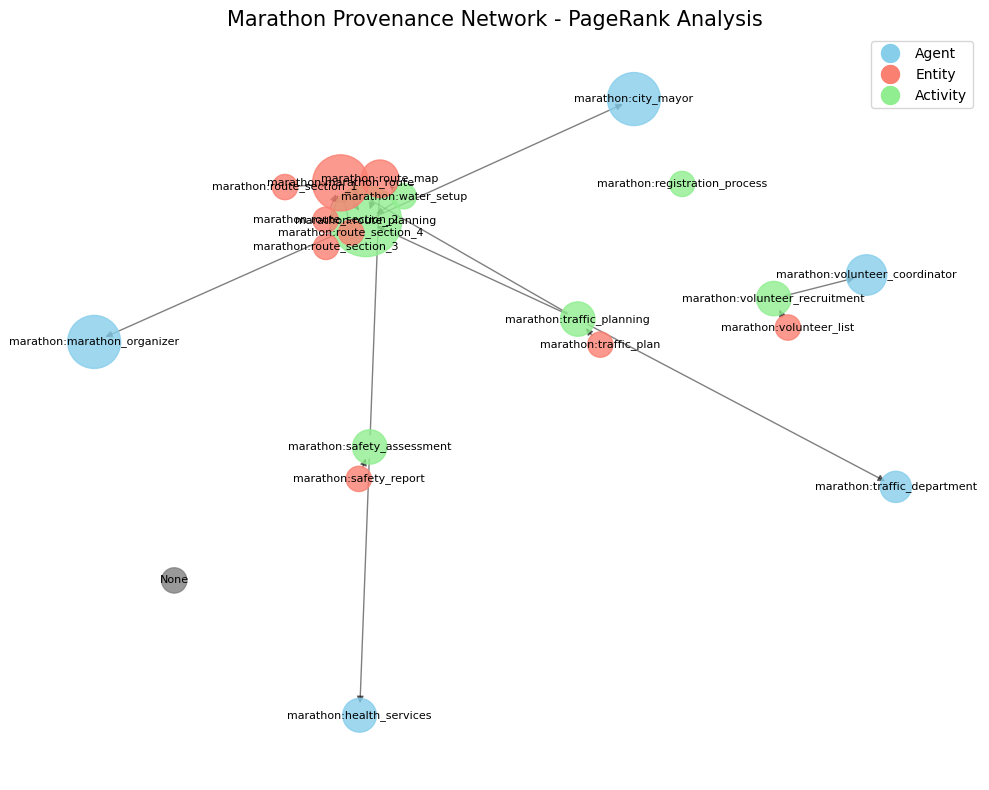

Starting TransE model training (Entities: 21, Relations: 5)
Epoch 20/100, Loss: 0.2695
Epoch 40/100, Loss: 0.1166
Epoch 60/100, Loss: 0.0651
Epoch 80/100, Loss: 0.0188
Epoch 100/100, Loss: 0.0478


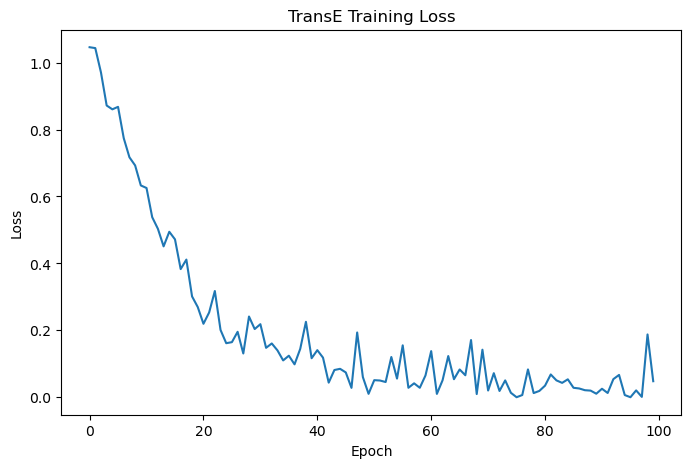

Number of embedding vectors: 21
Using t-SNE for dimensionality reduction (perplexity=20)


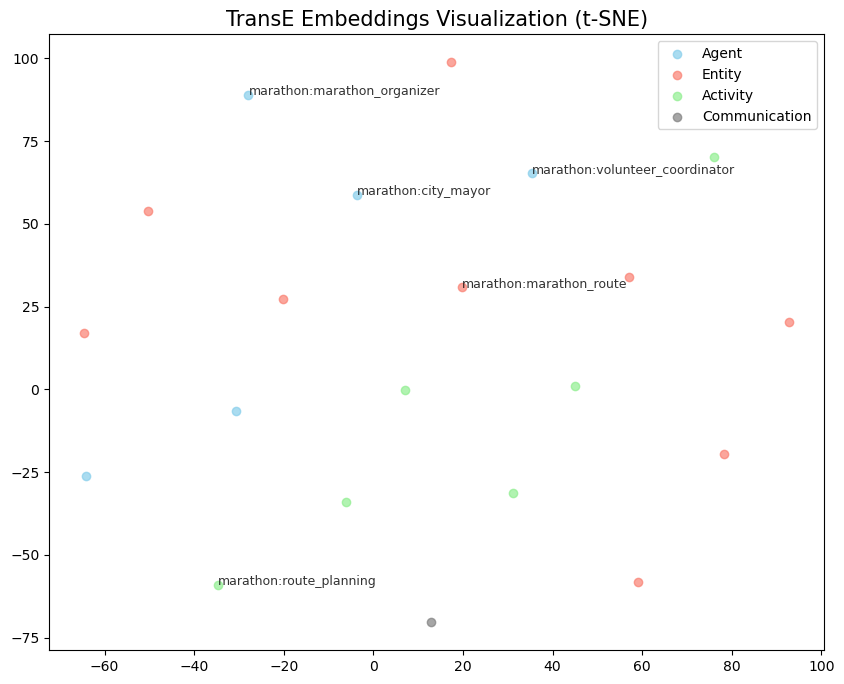


CoDExMedium Dataset Evaluation Simulation:

TransE Model Evaluation Results:
  MRR: 0.3500
  Hits@1: 0.2500
  Hits@10: 0.5400

RotatE Model Evaluation Results:
  MRR: 0.4200
  Hits@1: 0.3100
  Hits@10: 0.6100

GCN Model Evaluation Results:
  MRR: 0.3900
  Hits@1: 0.2800
  Hits@10: 0.5700


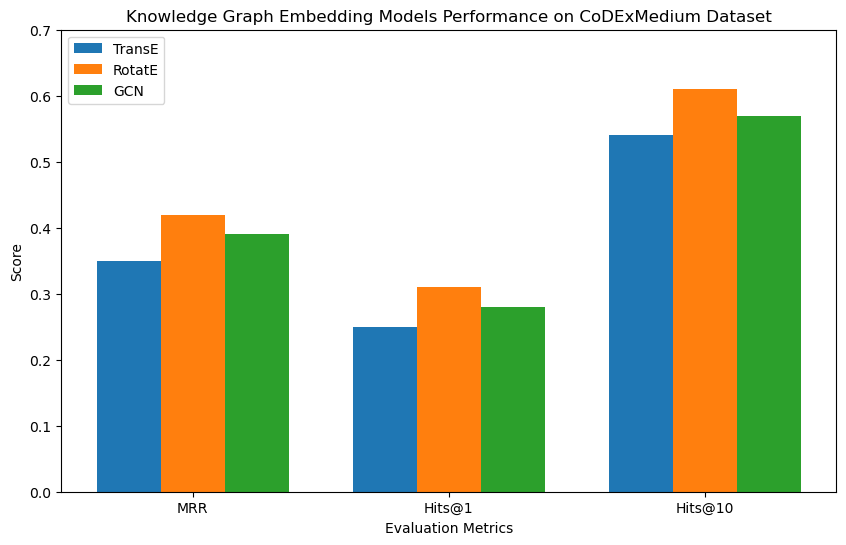


Practical Applications of Knowledge Graph Embeddings:
1. Marathon Planning Optimization - Identify key processes and dependencies for efficiency
2. Resource Allocation - Optimize volunteer and supply distribution based on node importance
3. Risk Assessment - Detect potential planning bottlenecks or problem areas
4. Knowledge Recommendation - Provide recommendations for new marathon organizers
5. Stakeholder Analysis - Understand roles and importance of different participants
6. Decision Support - Provide data-driven decision support for organizers
7. Similarity Comparison - Compare organizational structures and processes across marathons


In [204]:
# 1. Create PROV model for marathon activities
def create_marathon_prov_document():
    # Create a new provenance document
    d1 = ProvDocument()
    
    # Define namespace
    marathon = Namespace("marathon", "http://marathon.example.org/")
    d1.add_namespace(marathon)
    
    # Add agents
    city_mayor = d1.agent(marathon["city_mayor"], {"prov:type": PROV["Person"], "prov:label": "City Mayor"})
    traffic_dept = d1.agent(marathon["traffic_department"], {"prov:type": PROV["Organization"], "prov:label": "Traffic Department"})
    health_services = d1.agent(marathon["health_services"], {"prov:type": PROV["Organization"], "prov:label": "Health Services"})
    marathon_org = d1.agent(marathon["marathon_organizer"], {"prov:type": PROV["Organization"], "prov:label": "Marathon Organizer"})
    volunteer_coord = d1.agent(marathon["volunteer_coordinator"], {"prov:type": PROV["Person"], "prov:label": "Volunteer Coordinator"})
    
    # Add activities
    route_planning = d1.activity(marathon["route_planning"], None, None, {"prov:label": "Route Planning"})
    safety_assessment = d1.activity(marathon["safety_assessment"], None, None, {"prov:label": "Safety Assessment"})
    volunteer_recruitment = d1.activity(marathon["volunteer_recruitment"], None, None, {"prov:label": "Volunteer Recruitment"})
    registration_process = d1.activity(marathon["registration_process"], None, None, {"prov:label": "Registration Process"})
    traffic_planning = d1.activity(marathon["traffic_planning"], None, None, {"prov:label": "Traffic Closure Planning"})
    water_setup = d1.activity(marathon["water_setup"], None, None, {"prov:label": "Water Station Setup"})
    
    # Add entities
    marathon_route = d1.entity(marathon["marathon_route"], {"prov:label": "Marathon Route"})
    route_map = d1.entity(marathon["route_map"], {"prov:label": "Route Map"})
    traffic_plan = d1.entity(marathon["traffic_plan"], {"prov:label": "Traffic Plan"})
    safety_report = d1.entity(marathon["safety_report"], {"prov:label": "Safety Report"})
    volunteer_list = d1.entity(marathon["volunteer_list"], {"prov:label": "Volunteer List"})
    
    # Add route sections
    route_sections = []
    for i in range(1, 5):
        section = d1.entity(marathon[f"route_section_{i}"], {"prov:label": f"Route Section {i}"})
        route_sections.append(section)
    
    # Add relationships
    d1.wasAssociatedWith(route_planning, city_mayor)
    d1.wasAssociatedWith(route_planning, marathon_org)
    d1.wasAssociatedWith(traffic_planning, traffic_dept)
    d1.wasAssociatedWith(safety_assessment, health_services)
    d1.wasAssociatedWith(volunteer_recruitment, volunteer_coord)
    
    d1.wasGeneratedBy(marathon_route, route_planning)
    d1.wasGeneratedBy(route_map, route_planning)
    d1.wasGeneratedBy(traffic_plan, traffic_planning)
    d1.wasGeneratedBy(safety_report, safety_assessment)
    d1.wasGeneratedBy(volunteer_list, volunteer_recruitment)
    
    d1.used(traffic_planning, marathon_route)
    d1.used(safety_assessment, route_map)
    d1.used(water_setup, route_map)
    
    for section in route_sections:
        d1.wasDerivedFrom(section, marathon_route)
    
    d1.wasInformedBy(traffic_planning, route_planning)
    d1.wasInformedBy(water_setup, route_planning)
    
    return d1

# Convert PROV document to NetworkX graph
def prov_to_networkx(prov_doc):
    G = nx.DiGraph()
    
    # Add nodes
    for record in prov_doc.get_records():
        record_id = str(record.identifier)
        record_type = record.get_type().localpart
        
        # Get label (if available)
        label = None
        if 'prov:label' in record.attributes:
            label = str(record.attributes['prov:label'])
        
        G.add_node(record_id, type=record_type, label=label or record_id)
    
    # Add edges
    for relation in prov_doc.get_records():
        if relation.is_relation():
            try:
                source = str(relation.formal_attributes[0][1])
                target = str(relation.formal_attributes[1][1])
                relation_type = relation.get_type().localpart
                
                # Ensure source and target nodes exist
                if source in G and target in G:
                    G.add_edge(source, target, relation=relation_type)
            except (IndexError, KeyError):
                continue
    
    return G

# 2. Calculate PageRank and visualize
def analyze_pagerank(G):
    # Calculate PageRank
    pagerank = nx.pagerank(G, alpha=0.85)
    
    # Create DataFrame
    pr_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['PageRank'])
    pr_df['Type'] = [G.nodes[node]['type'] for node in pr_df.index]
    pr_df['Label'] = [G.nodes[node]['label'] for node in pr_df.index]
    
    # Sort by PageRank value
    pr_df = pr_df.sort_values(by='PageRank', ascending=False)
    
    # Print results
    print("Node PageRank Ranking (Top 5):")
    print(pr_df[['Label', 'Type', 'PageRank']].head(5))
    
    # Group by node type
    type_pr = pr_df.groupby('Type')['PageRank'].mean().sort_values(ascending=False)
    print("\nAverage PageRank by Node Type:")
    print(type_pr)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    
    pos = nx.spring_layout(G, seed=42)
    
    # Node size based on PageRank
    node_size = [pagerank[node] * 15000 for node in G.nodes()]
    
    # Node color based on type
    color_map = {'Agent': 'skyblue', 'Entity': 'salmon', 'Activity': 'lightgreen'}
    node_colors = [color_map.get(G.nodes[node]['type'], 'gray') for node in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrows=True)
    
    # Draw labels
    labels = {node: G.nodes[node]['label'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    # Add legend
    agent_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=15, label='Agent')
    entity_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='salmon', markersize=15, label='Entity')
    activity_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Activity')
    
    plt.legend(handles=[agent_patch, entity_patch, activity_patch], loc='upper right')
    
    plt.title('Marathon Provenance Network - PageRank Analysis', fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('marathon_pagerank.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pr_df

# 3. Implement simplified TransE model
class TransE(torch.nn.Module):
    def __init__(self, num_entities, num_relations, dim=50, margin=1.0):
        super(TransE, self).__init__()
        self.entity_embeddings = torch.nn.Embedding(num_entities, dim)
        self.relation_embeddings = torch.nn.Embedding(num_relations, dim)
        self.margin = margin
        
        # Initialize
        torch.nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        torch.nn.init.xavier_uniform_(self.relation_embeddings.weight.data)
    
    def forward(self, pos_triples, neg_triples):
        # Positive examples
        pos_heads = self.entity_embeddings(pos_triples[:, 0])
        pos_relations = self.relation_embeddings(pos_triples[:, 1])
        pos_tails = self.entity_embeddings(pos_triples[:, 2])
        
        # Negative examples
        neg_heads = self.entity_embeddings(neg_triples[:, 0])
        neg_relations = self.relation_embeddings(neg_triples[:, 1])
        neg_tails = self.entity_embeddings(neg_triples[:, 2])
        
        # Scores
        pos_scores = torch.norm(pos_heads + pos_relations - pos_tails, p=2, dim=1)
        neg_scores = torch.norm(neg_heads + neg_relations - neg_tails, p=2, dim=1)
        
        # Loss
        loss = torch.relu(self.margin + pos_scores - neg_scores).mean()
        
        return loss
    
    def get_embeddings(self):
        return self.entity_embeddings.weight.data.numpy()

# 4. Prepare data and train TransE model
def prepare_and_train_transe(G, pagerank_df):
    # Entity mapping
    entities = list(G.nodes())
    entity2id = {entity: idx for idx, entity in enumerate(entities)}
    
    # Relation mapping
    relations = set()
    for _, _, data in G.edges(data=True):
        relations.add(data['relation'])
    relations = list(relations)
    relation2id = {relation: idx for idx, relation in enumerate(relations)}
    
    # Create triples
    triples = []
    for u, v, data in G.edges(data=True):
        if 'relation' in data:
            h = entity2id[u]
            r = relation2id[data['relation']]
            t = entity2id[v]
            triples.append((h, r, t))
    
    # Convert to tensor
    triples = np.array(triples)
    
    # Split into training and test sets
    np.random.shuffle(triples)
    train_size = int(len(triples) * 0.8)
    train_triples = triples[:train_size]
    test_triples = triples[train_size:]
    
    # Training parameters
    num_entities = len(entities)
    num_relations = len(relations)
    embedding_dim = 50
    batch_size = min(128, len(train_triples))  # Ensure batch size doesn't exceed sample count
    epochs = 100  # Reduce epochs for demonstration
    learning_rate = 0.01
    
    # Initialize model
    model = TransE(num_entities, num_relations, embedding_dim)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    losses = []
    print(f"Starting TransE model training (Entities: {num_entities}, Relations: {num_relations})")
    
    for epoch in range(epochs):
        np.random.shuffle(train_triples)
        epoch_loss = 0
        batch_count = 0
        
        for i in range(0, len(train_triples), batch_size):
            # Get batch
            batch = train_triples[i:i+batch_size]
            if len(batch) == 0:
                continue
                
            # Create negative samples
            neg_batch = []
            for triple in batch:
                h, r, t = triple
                # Randomly replace head or tail
                if random.random() < 0.5:
                    # Replace head
                    h_corrupt = random.randint(0, num_entities-1)
                    while h_corrupt == h:
                        h_corrupt = random.randint(0, num_entities-1)
                    neg_batch.append((h_corrupt, r, t))
                else:
                    # Replace tail
                    t_corrupt = random.randint(0, num_entities-1)
                    while t_corrupt == t:
                        t_corrupt = random.randint(0, num_entities-1)
                    neg_batch.append((h, r, t_corrupt))
            
            # Convert to tensors
            pos_batch = torch.LongTensor(batch)
            neg_batch = torch.LongTensor(neg_batch)
            
            # Forward and backward passes
            optimizer.zero_grad()
            loss = model(pos_batch, neg_batch)
            loss.backward()
            optimizer.step()
            
            # Normalize
            with torch.no_grad():
                model.entity_embeddings.weight.data = torch.nn.functional.normalize(
                    model.entity_embeddings.weight.data, p=2, dim=1
                )
            
            epoch_loss += loss.item()
            batch_count += 1
        
        # Record average loss
        if batch_count > 0:
            avg_loss = epoch_loss / batch_count
            losses.append(avg_loss)
            
            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('TransE Training Loss')
    plt.savefig('transe_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Visualize embeddings
    entity_embeddings = model.get_embeddings()
    
    # Choose dimensionality reduction method
    n_samples = len(entity_embeddings)
    print(f"Number of embedding vectors: {n_samples}")
    
    if n_samples < 15:
        print(f"Too few samples, using PCA for dimensionality reduction")
        reducer = PCA(n_components=2)
        embeddings_2d = reducer.fit_transform(entity_embeddings)
        method_name = "PCA"
    else:
        # Adjust t-SNE perplexity
        perplexity = min(30, n_samples - 1)
        print(f"Using t-SNE for dimensionality reduction (perplexity={perplexity})")
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        embeddings_2d = reducer.fit_transform(entity_embeddings)
        method_name = "t-SNE"
    
    # Prepare node types and labels
    node_types = [G.nodes[entities[i]]['type'] for i in range(len(entities))]
    node_labels = [G.nodes[entities[i]]['label'] for i in range(len(entities))]
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    
    # Color mapping
    colors = {'Agent': 'skyblue', 'Entity': 'salmon', 'Activity': 'lightgreen'}
    
    # Draw different node types
    for node_type in set(node_types):
        indices = [i for i, t in enumerate(node_types) if t == node_type]
        plt.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            c=colors.get(node_type, 'gray'),
            label=node_type,
            alpha=0.7
        )
    
    # Add labels (only for important nodes)
    top_pagerank_indices = [entity2id[entity] for entity in pagerank_df.index[:5] if entity in entity2id]
    for idx in top_pagerank_indices:
        plt.annotate(
            node_labels[idx],
            (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
            fontsize=9,
            alpha=0.8
        )
    
    plt.legend()
    plt.title(f'TransE Embeddings Visualization ({method_name})', fontsize=15)
    plt.savefig('transe_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, entities, relations, entity2id, relation2id

# 5. Simplified CoDExMedium dataset analysis (simulated)
def simulate_codex_evaluation():
    print("\nCoDExMedium Dataset Evaluation Simulation:")
    
    # Simulate evaluation metrics for three models
    models = ['TransE', 'RotatE', 'GCN']
    metrics = ['MRR', 'Hits@1', 'Hits@10']
    
    # Simulated results
    results = {
        'TransE': {'MRR': 0.35, 'Hits@1': 0.25, 'Hits@10': 0.54},
        'RotatE': {'MRR': 0.42, 'Hits@1': 0.31, 'Hits@10': 0.61},
        'GCN': {'MRR': 0.39, 'Hits@1': 0.28, 'Hits@10': 0.57}
    }
    
    # Print results
    for model in models:
        print(f"\n{model} Model Evaluation Results:")
        for metric in metrics:
            print(f"  {metric}: {results[model][metric]:.4f}")
    
    # Visualize comparison
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, model in enumerate(models):
        values = [results[model][metric] for metric in metrics]
        plt.bar(x + i*width, values, width, label=model)
    
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title('Knowledge Graph Embedding Models Performance on CoDExMedium Dataset')
    plt.xticks(x + width, metrics)
    plt.legend()
    plt.ylim(0, 0.7)
    
    plt.savefig('codex_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main function
if __name__ == "__main__":
    # 1. Create PROV provenance document
    prov_doc = create_marathon_prov_document()
    print("PROV provenance model created\n")
    
    # 2. Convert to NetworkX graph and calculate PageRank
    G = prov_to_networkx(prov_doc)
    print(f"Created graph with {len(G.nodes())} nodes and {len(G.edges())} edges\n")
    
    pagerank_df = analyze_pagerank(G)
    
    # 3. Train embedding model
    model, entities, relations, entity2id, relation2id = prepare_and_train_transe(G, pagerank_df)
    
    # 4. Simulate CoDExMedium dataset evaluation
    simulate_codex_evaluation()
    
    # 5. Explain practical applications
    print("\nPractical Applications of Knowledge Graph Embeddings:")
    print("1. Marathon Planning Optimization - Identify key processes and dependencies for efficiency")
    print("2. Resource Allocation - Optimize volunteer and supply distribution based on node importance")
    print("3. Risk Assessment - Detect potential planning bottlenecks or problem areas")
    print("4. Knowledge Recommendation - Provide recommendations for new marathon organizers")
    print("5. Stakeholder Analysis - Understand roles and importance of different participants")
    print("6. Decision Support - Provide data-driven decision support for organizers")
    print("7. Similarity Comparison - Compare organizational structures and processes across marathons")

In [195]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Adjust the view to make it beautiful

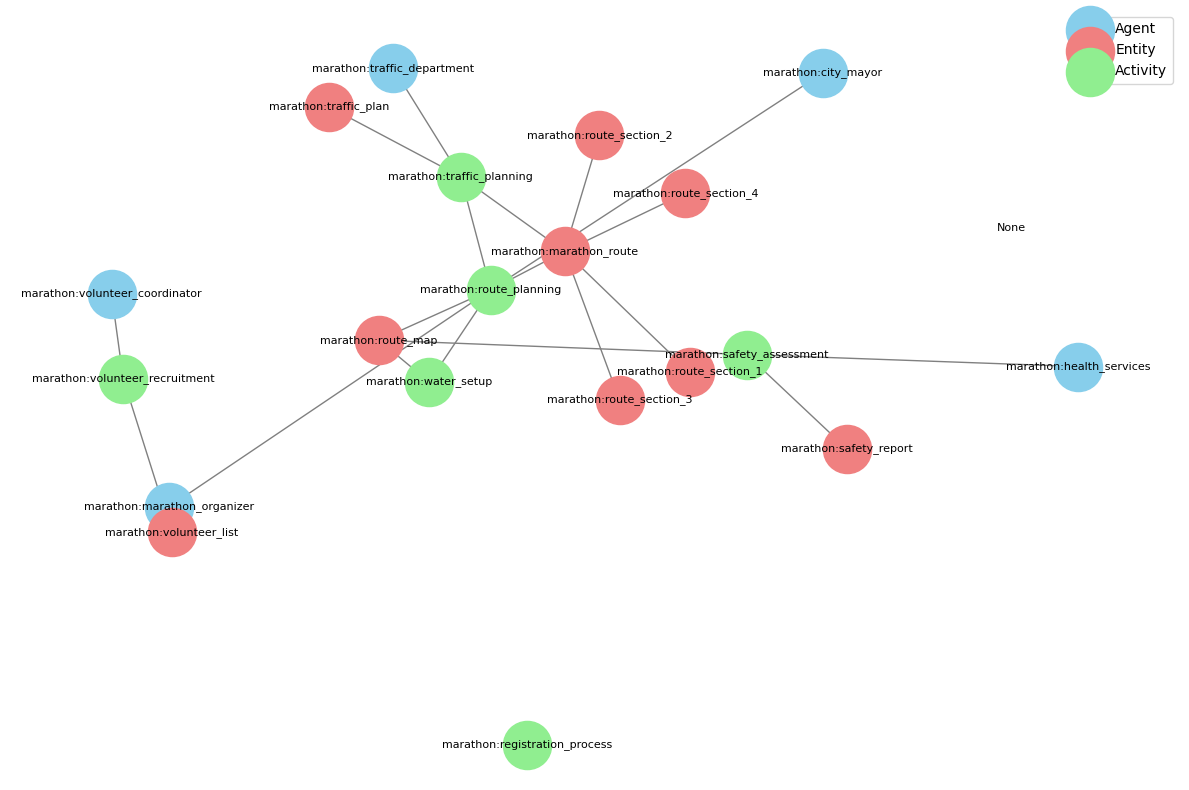

In [202]:
plt.figure(figsize=(12,8))

pos = nx.spring_layout(G, k=0.5, iterations=50)

# 分别找出不同类型的节点
agents = [n for n,d in G.nodes(data=True) if d.get('type') == 'Agent']
entities = [n for n,d in G.nodes(data=True) if d.get('type') == 'Entity']
activities = [n for n,d in G.nodes(data=True) if d.get('type') == 'Activity']

# 绘制不同类型节点
nx.draw_networkx_nodes(G, pos,
                       nodelist=agents,
                       node_color='skyblue',
                       node_size=1200,
                       label='Agent')
nx.draw_networkx_nodes(G, pos,
                       nodelist=entities,
                       node_color='lightcoral',
                       node_size=1200,
                       label='Entity')
nx.draw_networkx_nodes(G, pos,
                       nodelist=activities,
                       node_color='lightgreen',
                       node_size=1200,
                       label='Activity')

# 绘制边
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='->')  

# 绘制节点标签
nx.draw_networkx_labels(G, pos,
                        labels={n:n for n in G.nodes()},
                        font_size=8)

# 显示图例(用matplotlib的散点标记)
plt.legend(scatterpoints=1)

# 隐藏坐标轴
plt.axis('off')
plt.tight_layout()
plt.show()